<a href="https://colab.research.google.com/github/Ni-cole17/PDS/blob/main/Trabalho_PDS_Epilepsiae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas e drive

In [ ]:
# Fazer uma cópia do drive aqui no colab para facilitar a aquisição da base de dados
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Algumas bibliotecas utilizadas no desenvolvimento
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis
from numpy import abs, arange, log10, unwrap, angle, pi, int16, array
from scipy.signal import firwin, filtfilt, freqz
from scipy.fft import fft, fftfreq
from os import getcwd
from scipy.io import loadmat
import pandas as pd  
from scipy import signal  
import math
import csv

# Definição das funções utilizadas no projeto

In [ ]:
#Código para obter todos os arquivos dentro de uma dada pasta, recebe uma variável pasta que contém o diretório dos dados e guarda
#na variável filenames o nome de todos os arquivos daquela pasta.
def ler_pasta(pastas):
  filenames = []
  pasta = pastas
  for diretorio, subpastas, arquivos in os.walk(pasta):
    for arquivo in arquivos:
        filenames.append(arquivo)
  print(filenames)
  return filenames

In [ ]:
#Função para carregar os dados do arquivo .mat e transformar em um numpy array que será guardado na variável dados.
def carrega_dados(filename,T):
  diretorio = '/content/drive/MyDrive/Trabalho-PDS/dados_epilepsia/Epilepsia/' + T +'/'+filename
  x = loadmat(diretorio)
  dados = x['X']
  return dados

In [ ]:
#Função para a plotagem do sinal no domínio do tempo e da frequência.
def temp_grafico_freq(x,fs, titulo = "",freq = True): # Recebe os parâmetros x e fs, que são o nosso vetor com os dados e fs que é a frequencia de amostragem
  N_pontos = len(x) 
  ts = 1 / fs # Período de amostragem
  t = arange(0, N_pontos) * ts # Domínio com o mesmo tamanho do vetor x e dividido pela frequência de amostragem 
  
  if freq == True:
    figure, (ax1,ax2) = plt.subplots(2, 1,figsize=(18,9))
    frequenciaHz = fftfreq(N_pontos, ts) # Utilização da transformada discreta de fourier para a mudança do domínio do tempo para frequência
    Xf = fft(x) # Calcula a transformada discreta de fourier de uma dada função
    ax2.plot(frequenciaHz, abs(Xf), linewidth=2)
    ax2.set_title("Domínio da Frequência" + titulo)
    ax2.set_xlabel("Frequencia [Hz]")
    ax2.set_ylabel("Módulo de X(f)")
    ax2.grid()
  else:
    figure, ax1 = plt.subplots(1, 1,figsize=(18,5))

  ax1.plot(t, x, linewidth=2)
  ax1.set_title("Domínio do tempo" + titulo)
  ax1.set_xlabel("Time(s)")
  ax1.set_ylabel("Amplitude")
  ax1.grid()

  plt.subplots_adjust(top=0.94, hspace=0.5, left=0.183)
  plt.show()

In [ ]:
def janelamento(sinal,janela): #Função que recebe o sinal a ser janelado e o tamanho da janela (SEM SOBREPOSIÇÃO)
  start = 0 # Começa na posição 0 do vetor
  stop = janela # Termina na primeira janela
  janelas = [] # Vetor que vai guardar o sinal janelado
  for j in range(0,len(sinal),janela): # Iteração que vai de 0 até o tamanho do sinal pulando a cada tamanho de janela (step)

    # Só para vizualizar o que está acontecendo
    #print("start: ",start)
    #print("stop: ",stop)
    #print("tamanho: ",len(sinal[start:stop]))
    #print("vetor: ",sinal[start:stop]) 

    janelas.append(sinal[start:stop]) # Colocar o vetor resultante no vetor janelas que irá ser retornado

    # Definição de um novo start e de um novo stop para o recorte da próxima janela
    start = stop 
    stop = stop + janela

  return janelas

In [ ]:
def janelamento_sbp(sinal,jan,sbp,fs): #Função que recebe o sinal a ser janelado, o tamanho da janela e a sobreposição em segundos
  janela = int(jan*fs)
  start = 0 # Começa na posição 0 do vetor
  sobreposicao = int(sbp*fs)
  stop = janela # Termina na primeira janela
  janelas = [] # Vetor que vai guardar o sinal janelado
  for j in range(0,len(sinal),janela): # Iteração que vai de 0 até o tamanho do sinal pulando a cada tamanho de janela (step)
    janelas.append(sinal[start:stop]) # Colocar o vetor resultante no vetor janelas que irá ser retornado
    # Definição de um novo start e de um novo stop para o recorte da próxima janela
    start = stop - sobreposicao
    stop = stop + janela - sobreposicao
  return janelas

In [ ]:
def filtro_butter(fc,ordem,fs): # Função de criação dos filtros, recebe as frequencias de corte, a ordem do filtro e a frequência de amostrage e retorna o coeficientes [b,a]
  nyq = 0.5 * fs
  low = fc[0]/ nyq
  high = fc[1]/ nyq
  coefs = signal.butter(ordem, [low,high], 'band')
  return coefs

In [ ]:
def visualizar_filtro(b,a,fs,fc): # Função para observar a resposta em frequência do nosso filtro e verificar qual a melhor ordem
  w, h = signal.freqz(b,a,fs=fs)
  plt.semilogx(w, 20 * np.log10(abs(h)))
  plt.title('Resposta em frequência - Filtro Passa-Banda')
  plt.xlabel('Frequência [radiano / segundo]')
  plt.ylabel('Amplitude [dB]')
  plt.margins(0, 0.1)
  plt.grid(which='both', axis='both')
  plt.axvline(fc[0], color='green') 
  plt.axvline(fc[1], color='green') 
  plt.show()

In [ ]:
# Função para extração de atirbutos

def atributos(k): 
# Como não vou mandar para essa função, todo o dataset
#vou enviar apenas um sinal.
#Esse sinal que corresponde a um canal de uma sobreposição que passou por 6 filtros.
#Por isso adaptei algumas coisas para conseguir funcionar
    
    
    # k is the dataset
    #[lin, col] = k.shape

    AAC = np.array([])
    DASDV = np.array([])
    IAV = np.array([])
    LOGD = np.array([])
    MAV = np.array([])
    MLOGK = np.array([])
    RMS = np.array([])
    KURT = np.array([])
    SSC = np.array([])
    SSI = np.array([])
    VAR = np.array([])
    WFL = np.array([])
    ZCS = np.array([])
    TM3= np.array([])
    TM4 = np.array([])
    TM5 = np.array([])
    STD = np.array([])
    MVAL = np.array([])
    MAX = np.array([])
    PSR = np.array([])
    PKF = np.array([])
    MNP = np.array([])
    MDF = np.array([])
    MNF = np.array([])
    TTP = np.array([])
    VCF = np.array([])
    SM1 = np.array([])
    SM2 = np.array([])
    SM3 = np.array([])


    lin = len(k) # Fez sentido fazer com que lin fosse o tamanho do sinal que eu recebo na função, visto que lin antes era o tamanho do sinal da base.
    # colocar o loop (o = 1:col)
    F, P = signal.periodogram(k)

    AAC = np.append(AAC, [[(1/lin)*(np.sum(np.abs(np.diff(k))))]])
    DASDV = np.append(DASDV,[[np.sqrt((1/(lin-1))*np.sum(np.diff(k)**2))]])
    IAV = np.append(IAV,[[np.sum(k)]])
    LOGD = np.append(LOGD, [[np.exp((1/lin)*(np.sum(np.log10(0.0001 + (np.abs(k))))))]])
    MAV = np.append(MAV, [[(1/lin)*(np.sum(np.abs(k)))]])
    MLOGK = np.append(MLOGK, [[(1/lin)*(np.abs(np.sum(k)))]])
    RMS = np.append(RMS, [[np.sqrt((1/lin)*(np.sum(k**2)))]])
    KURT = np.append(KURT, [[kurtosis(k)]])
    SSC = np.append(SSC, [[len(np.nonzero(np.diff(np.sign(np.diff(k)))))]])
    SSI = np.append(SSI, [[np.sum(k**2)]])
    VAR = np.append(VAR, [[np.var(k)]])
    WFL = np.append(WFL, [[0]])
    ZCS = np.append(ZCS,[[len(np.nonzero(np.diff(np.sign(k))))]])
    TM3 = np.append(TM3,[[np.abs((1/lin)*(np.sum(k**3)))]])
    TM4 = np.append(TM4,[[np.abs((1/lin)*(np.sum(k**4)))]])
    TM5 = np.append(TM5,[[np.abs((1/lin)*(np.sum(k**5)))]])
    STD = np.append(STD,[[np.std(k)]])
    MVAL = np.append(MVAL,[[(1/lin)*(np.sum(k))]])
    MAX = np.append(MAX,[[np.amax(k)]])
    PSR = np.append(PSR, [[((np.amax(P)/(np.sum(P))))]])
    MNF = np.append(MNF,[[np.sum(F*P)/np.sum(P)]])
    MNP = np.append(MNP,[[np.sum(P)/len(F)]])
    PKF = np.append(PKF,[[np.amax(P)]])
    TTP = np.append(TTP,[[np.sum(P)]])
    SM1 = np.append(SM1,[[np.sum(F*P)]])
    SM2 = np.append(SM2,[[np.sum((F**2)*P)]])
    SM3 = np.append(SM3,[[np.sum((F**3)*P)]])
    VCF = np.append(VCF,[[(((SM2/TTP) - ((SM1)/TTP))**2)]])
    MDF = np.append(MDF,[[[(1/2)*(np.sum(P))]]])


    allFeatures = np.hstack((AAC, DASDV, IAV, LOGD, MAV, MLOGK, RMS, KURT, SSC, SSI, VAR, WFL, ZCS, TM3, TM4, TM5, STD, MVAL, MAX, PSR, MNF, MNP, PKF, TTP, SM1, SM2, SM3, VCF, MDF))

    return allFeatures

In [ ]:
def janelamento_sob_extracao(dados,classe,janela,sobreposicao,fs): # Essa função, faz o janelamento, filtragem e extração de atributos dado uma base de dados
  atributos_canais = []
  atributos_janela = []
  atributos_arquivo = []
  atr_canal = []
  j = 0

  for arquivo in dados: # Pegar o sinal de cada arquivo
    print("Processando o arquivo: ",j+1) # Um print só para verificar o andamento do código, em qual arquivo ele está processando
    j = j + 1
    sinal_janelado = janelamento_sbp(arquivo,janela,sobreposicao,fs) # Fazer o janelamento


    for janela in sinal_janelado: # ir em cada janela
      for i in range(20): # Ir em cada canal
        filtrado1 = signal.filtfilt(coeficientes_filtros[0][0], coeficientes_filtros[0][1], janela[::,i]) # Filtro 1
        filtrado2 = signal.filtfilt(coeficientes_filtros[1][0], coeficientes_filtros[1][1], janela[::,i]) # filtro 2
        filtrado3 = signal.filtfilt(coeficientes_filtros[2][0], coeficientes_filtros[2][1], janela[::,i]) # filtro 3
        filtrado4 = signal.filtfilt(coeficientes_filtros[3][0], coeficientes_filtros[3][1], janela[::,i]) # filtro 4
        filtrado5 = signal.filtfilt(coeficientes_filtros[4][0], coeficientes_filtros[4][1], janela[::,i]) # filtro 5
        filtrado6 = signal.filtfilt(coeficientes_filtros[5][0], coeficientes_filtros[5][1], janela[::,i]) # filtro 6

        # ---- Extrair os atributos dos 6 filtros------
        atr1 = atributos(np.array(filtrado1))
        atr2 = atributos(np.array(filtrado2))
        atr3 = atributos(np.array(filtrado3))
        atr4 = atributos(np.array(filtrado4))
        atr5 = atributos(np.array(filtrado5))
        atr6 = atributos(np.array(filtrado6))
        #-----------------------------------------------------
        atr_canal.extend(atr1)
        atr_canal.extend(atr2)
        atr_canal.extend(atr3)
        atr_canal.extend(atr4)
        atr_canal.extend(atr5)
        atr_canal.extend(atr6) #atr_canal é o meu vetor que tem o resultado dos 6 vetores de atributos concatenados em um só de tamanho 6*29
        # Após fazer saber dos atributos de um canal filtrado
        atributos_canais.extend(atr_canal) #Concatenando os vetores de cada sinal filtrado para formar um só vetor que represente o canal
        atr_canal = []

      atributos_canais.append(classe) # Coloca a classe como último atributo
      atributos_janela.append(atributos_canais) #Colocando o vetor de contem os atributos dos 20 canais de uma janela em um outro vetor, para eu poder pegar a próxima janela na iteração do for
      atributos_canais = []
    
    atributos_arquivo.append(atributos_janela) # Colocando o vetor de atributos de todos os janelamentos de um arquivo em um vetor, para seguir para o próximo arquivo
    atributos_janela = []
    # É esperado que ao final o vetor atributos_arquivo tenha tamanho 13 ou 14, visto que são 13 ou 14 arquivos (dependendo da pasta).
    # Em cada um desses arquivos, espera-se que tenha um tamanho X, que corresponde a quantidade de janelamentos do sinal daquele arquivo
    # Por fim em cada janelamento, esperamos que tenha tamanho 20, visto que são 20 canais
    # E em cada canal tenha um tamanho de 6 x 29, visto que são 29 atributos por canal e cada canal passa por 6 filtros.
  return atributos_arquivo

In [ ]:
def criar_csv(filename,num_atributos):
  nomes = []
  for i in range(num_atributos):
    nome = 'xp'+ str(i+1)
    nomes.append(nome)
  nomes.append('class')
  print(nomes)
  filename = filename;

  with open(filename, 'w', newline='') as nomes_atributos:
    writer = csv.writer(nomes_atributos)
    writer.writerow(nomes)

In [ ]:
def preencher_csv(filename,dados):
  for arquivo in dados: 
    with open(filename, 'a', newline='') as atributos_file:
      writer = csv.writer(atributos_file)
      for i in arquivo:
        writer.writerow(i)

# Leitura dos dados

In [ ]:
# Diretório dos dados da base de dados, dados1 tem os dados da pasta T0 e dados2 tem os dados da pasta T1
dados1 ='/content/drive/MyDrive/Trabalho-PDS/dados_epilepsia/Epilepsia/T0'
dados2 ='/content/drive/MyDrive/Trabalho-PDS/dados_epilepsia/Epilepsia/T1'

In [ ]:
# Criei uma variável dados, para conter os meus dados contidos na pasta T0, nele chamo a função ler_pasta e passo como parametro
# a variável dados1 onde tem o diretório da minha pasta T0 e em seguida chamo a funçao carrega_dados para cada um dos arquivos de T0
# e coloco esses dados na variável dados_T0.
dados_T0 = []
for i in ler_pasta(dados1):
  dados_T0.append(carrega_dados(i,'T0'))

['T0_p12.mat', 'T0_p11.mat', 'T0_p10.mat', 'T0_p1.mat', 'T0_p13.mat', 'T0_p2.mat', 'T0_p14.mat', 'T0_p4.mat', 'T0_p3.mat', 'T0_p5.mat', 'T0_p6.mat', 'T0_p8.mat', 'T0_p7.mat', 'T0_p9.mat']


In [ ]:
#Vou fazer o mesmo da célula acima, mas agora com os dados da pasta T1.
dados_T1 = []
for i in ler_pasta(dados2):
  dados_T1.append(carrega_dados(i,'T1'))

['T1_p1.mat', 'T1_p10.mat', 'T1_p11.mat', 'T1_p13.mat', 'T1_p12.mat', 'T1_p2.mat', 'T1_p4.mat', 'T1_p3.mat', 'T1_p5.mat', 'T1_p8.mat', 'T1_p6.mat', 'T1_p7.mat', 'T1_p9.mat']


# Plot do Sinal (Visualização)

In [ ]:
#Para começar a visualização do sinal, é preciso declarar a frequência de amostragem do sinal, pela base de dados identificamos que o sinal foi obtido com uma
#frequência de 500Hz, logo fs será 500hz. Fizemos isso para ver o tempo em segundos de aquisição do sinal.
fs = 500

## Arquivo T0_p12.mat

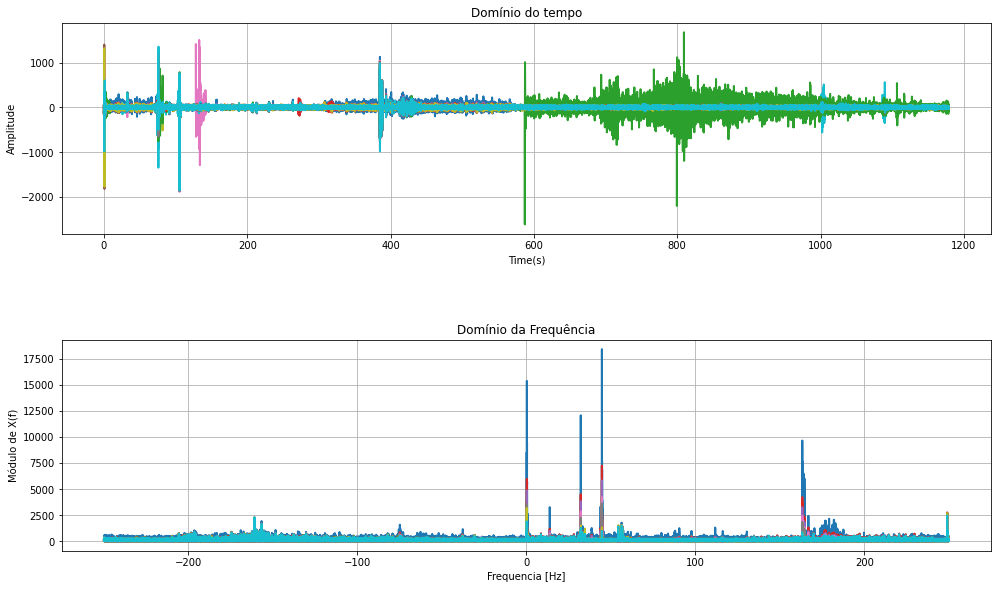

In [ ]:
#Escolhi representar os dados da primeira posição da variável dados_T0, que são os dados do primeiro arquivo da pasta T0, que nesse caso
# é o arquivo T0_p12.mat
x = dados_T0[0]
temp_grafico_freq(x,fs)

Após a observação do sinal acima, percebeu-se que cada sinal é formado por vários canais, por isso os gráficos estão com diversas cores. Dessa forma, vou visualizar cada um dos canais do sinal do arquivo T0_p12.mat separadamente 

In [ ]:
#primeiro vamos verificar quantos canais existem em cada sinal
x.shape

(589409, 20)

In [ ]:
print(x)

[[-107.331 -142.364 -142.08  ... -107.674  -13.353 -106.953]
 [-118.937 -156.092 -155.78  ... -119.313  -11.738 -118.524]
 [-123.015 -157.89  -157.575 ... -123.394   -5.623 -122.599]
 ...
 [   0.836    0.69     1.091 ...    5.154   -2.359   -4.401]
 [   2.949    1.211    3.189 ...    8.161   -1.386   -2.556]
 [   2.411    1.718    5.076 ...    8.267   -0.337   -4.261]]


In [ ]:
print(x[::,0]) # Pega o valor de todas as linhas da primeira coluna, ou seja, os valores do canal 1

[-107.331 -118.937 -123.015 ...    0.836    2.949    2.411]


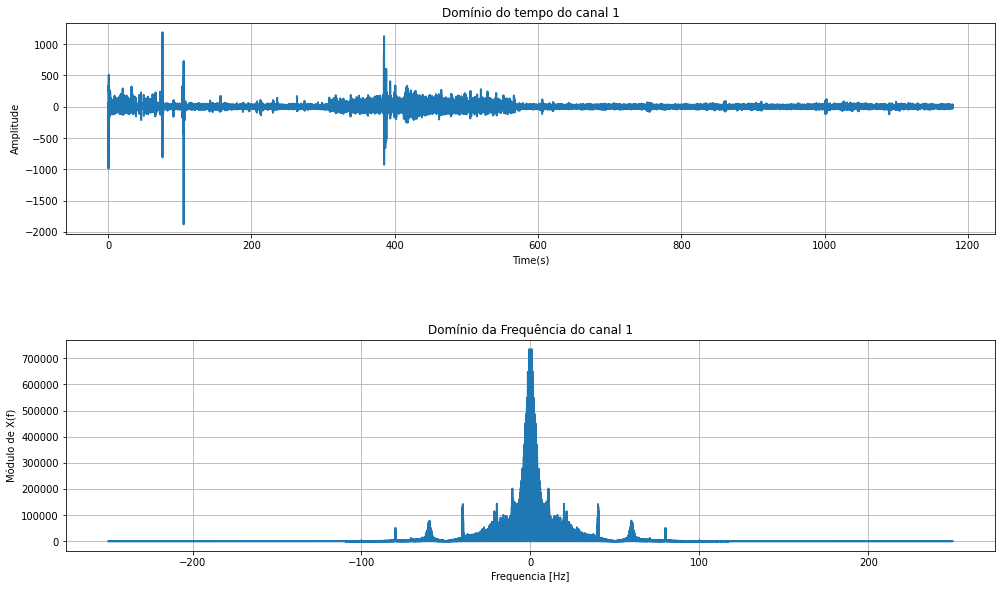

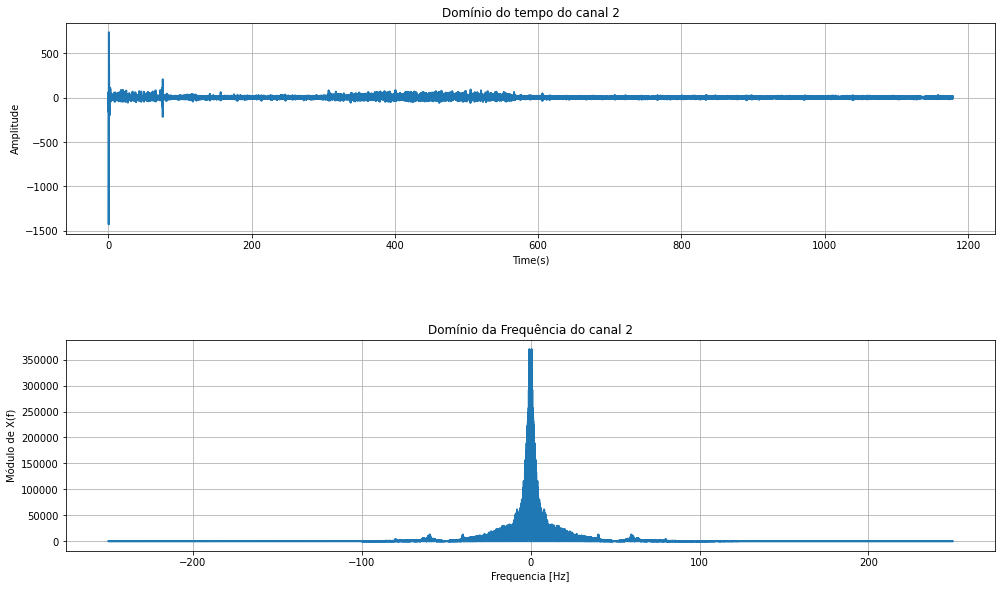

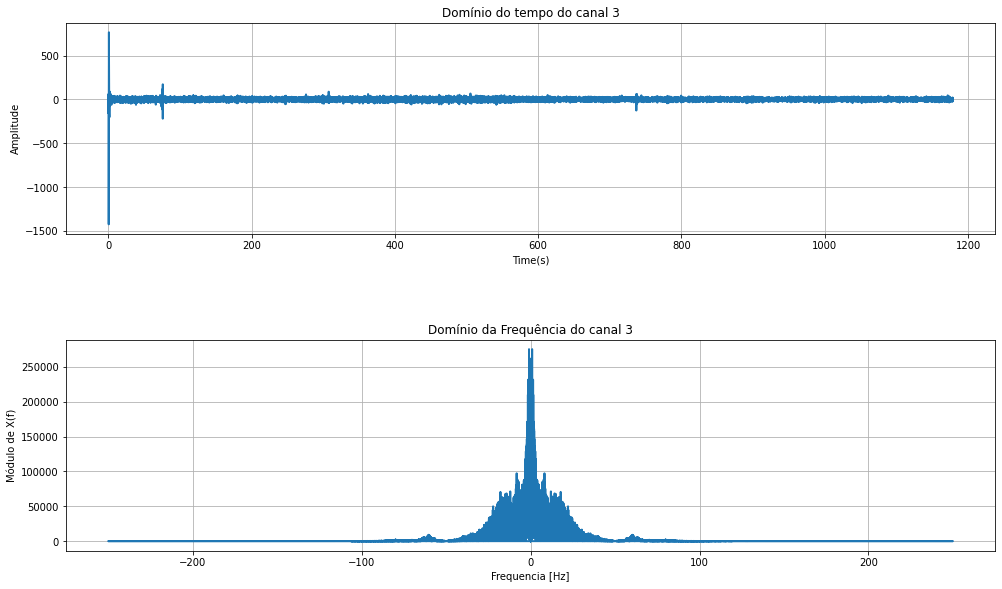

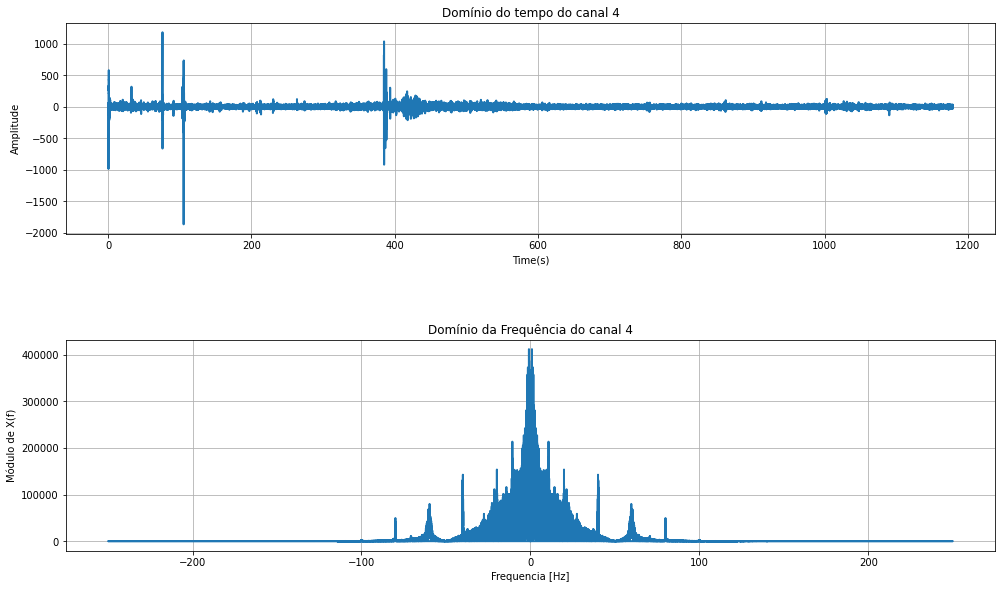

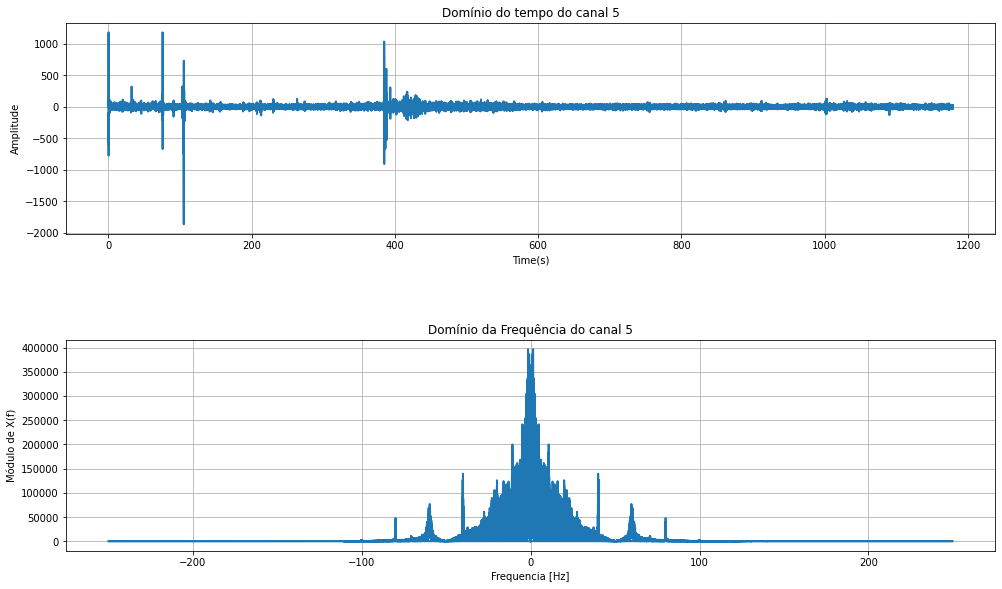

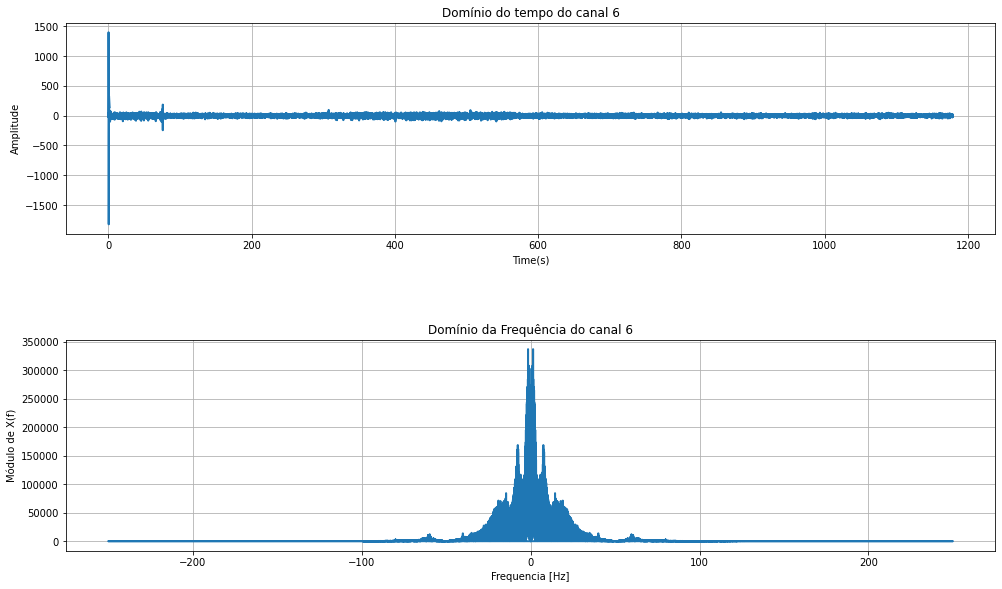

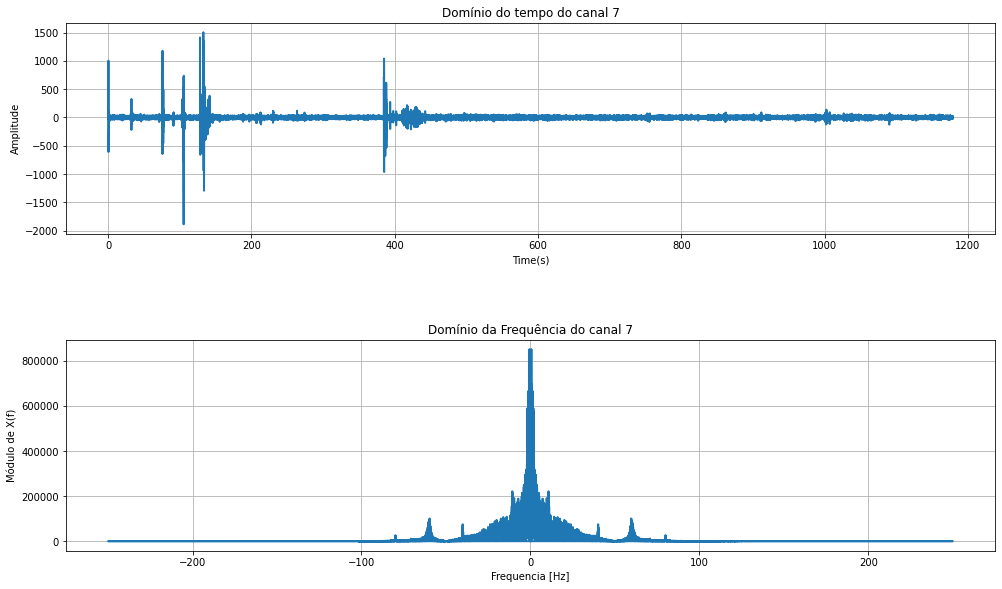

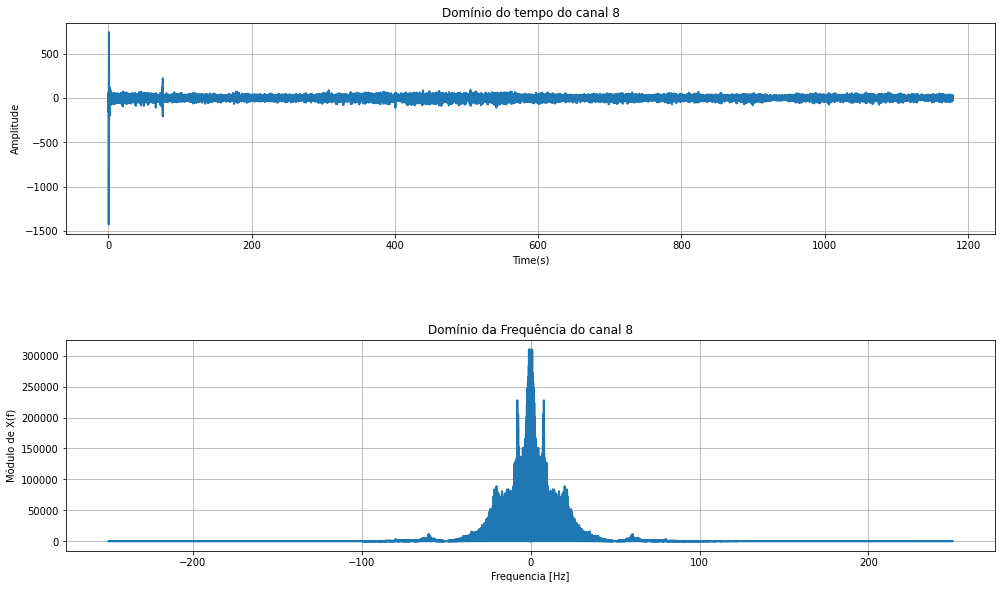

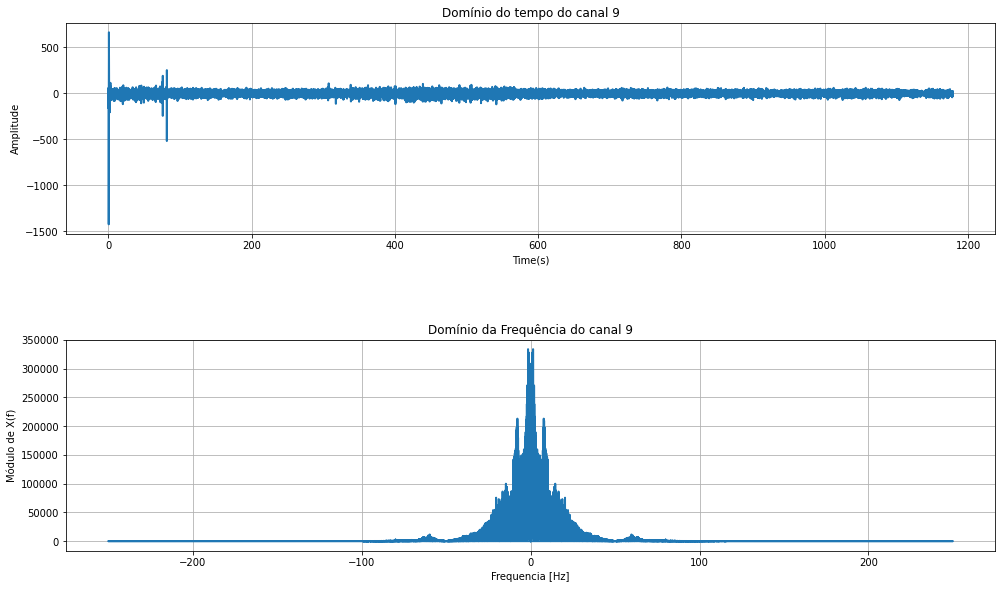

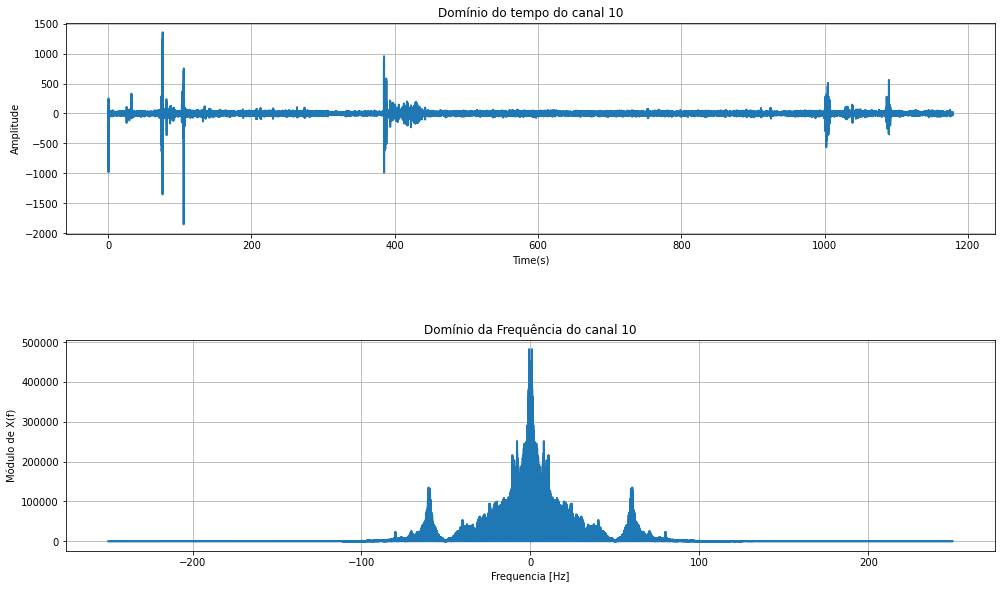

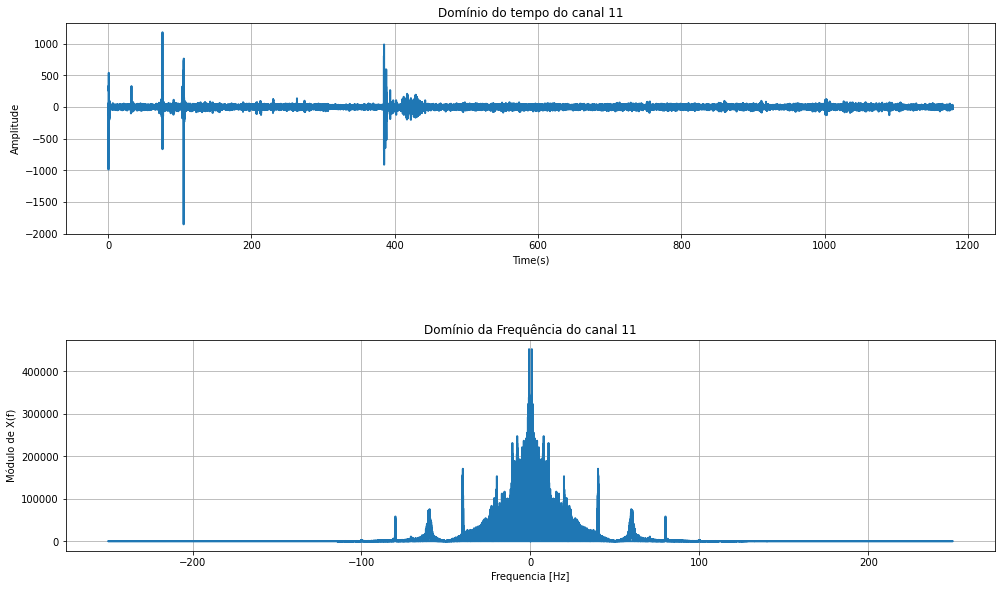

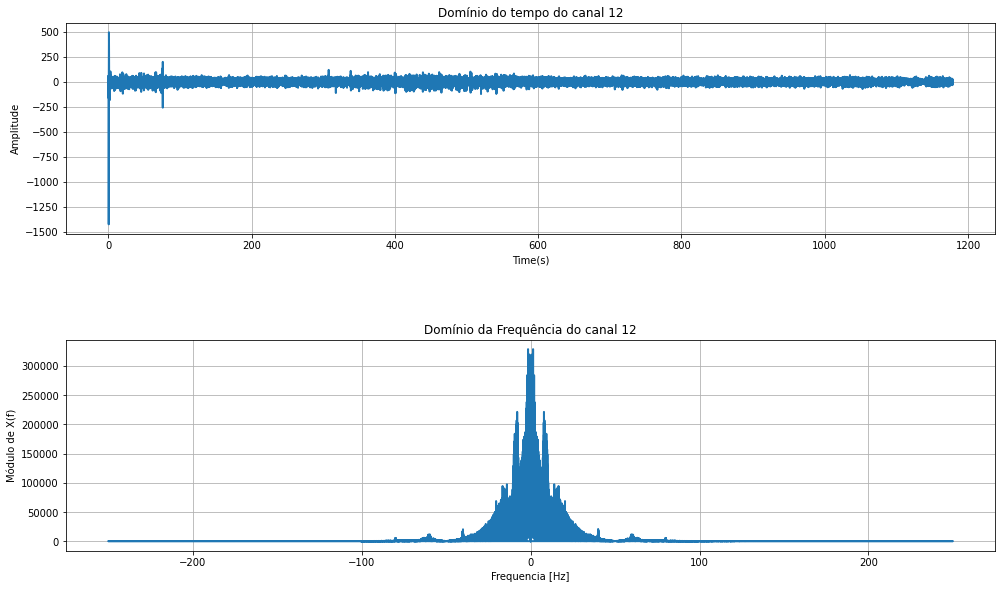

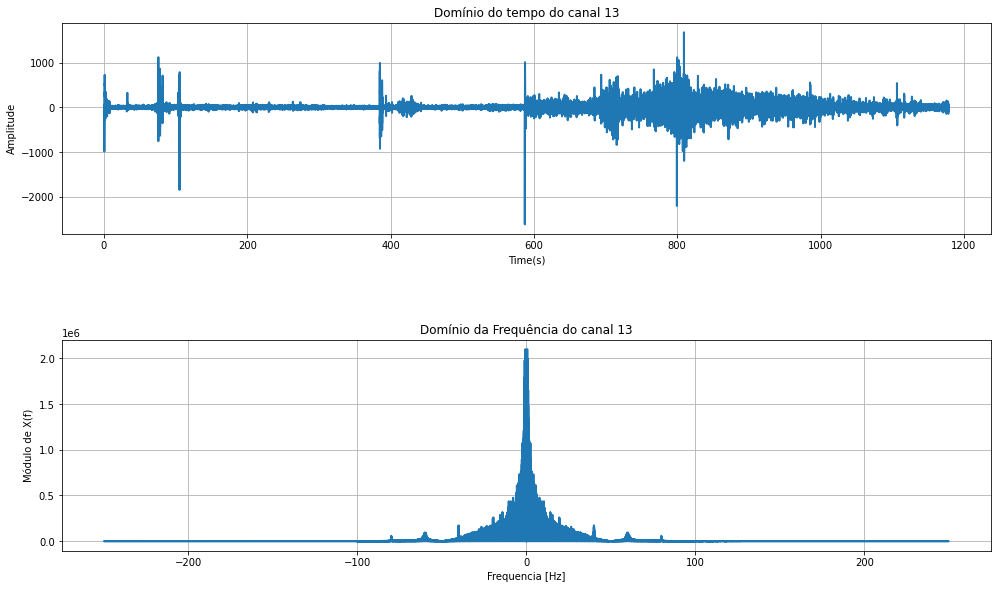

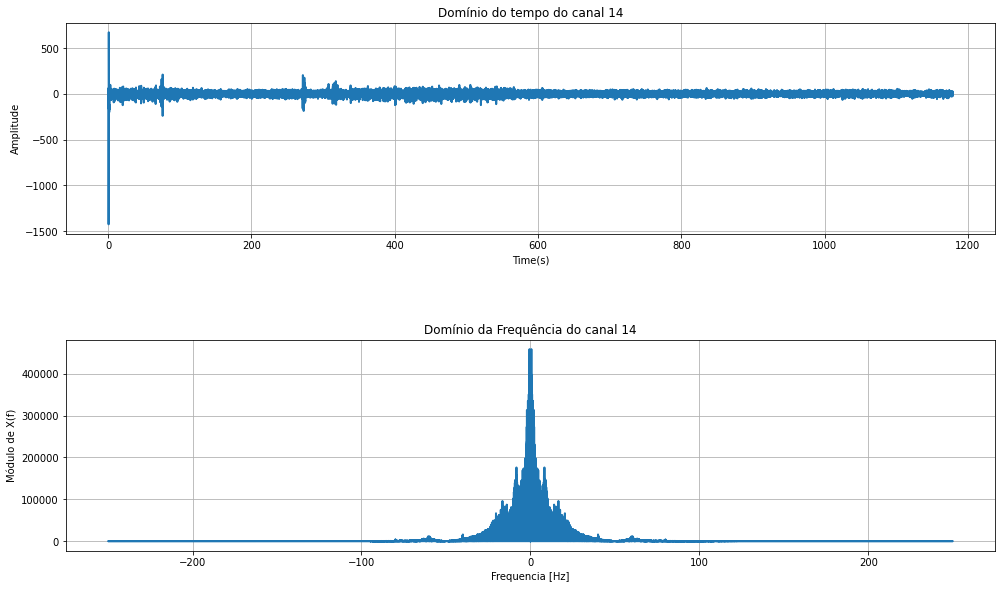

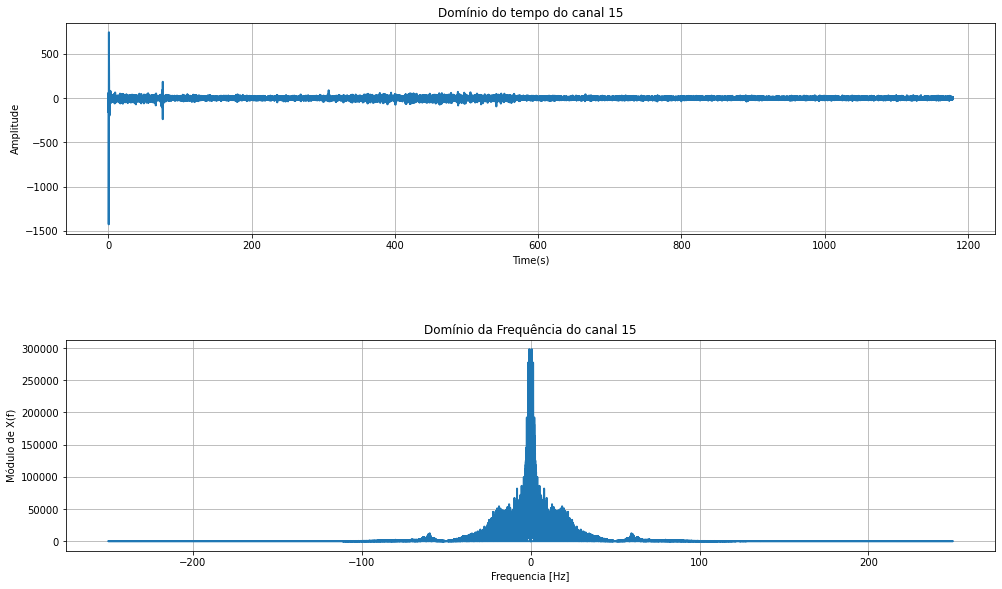

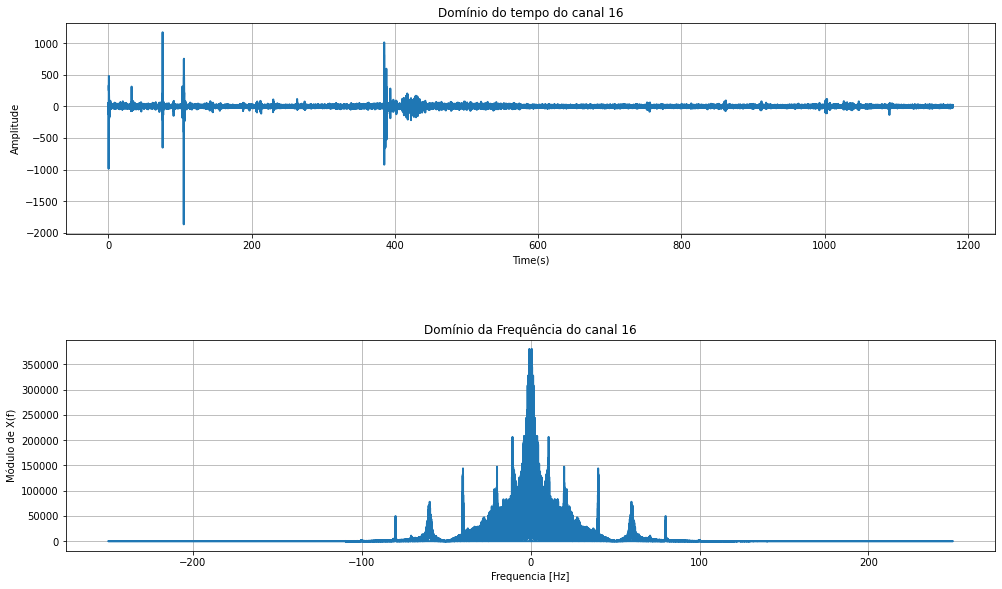

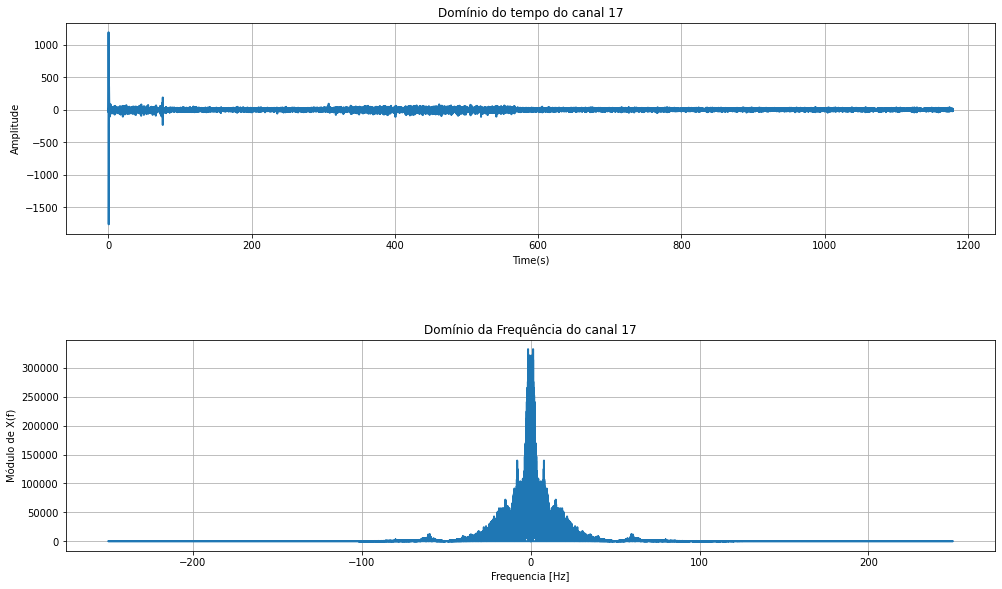

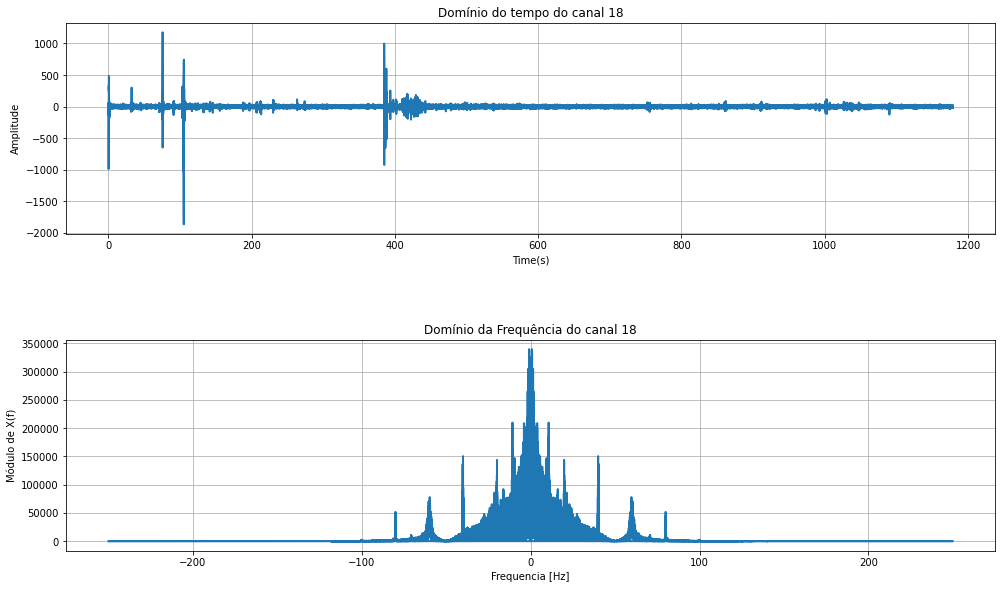

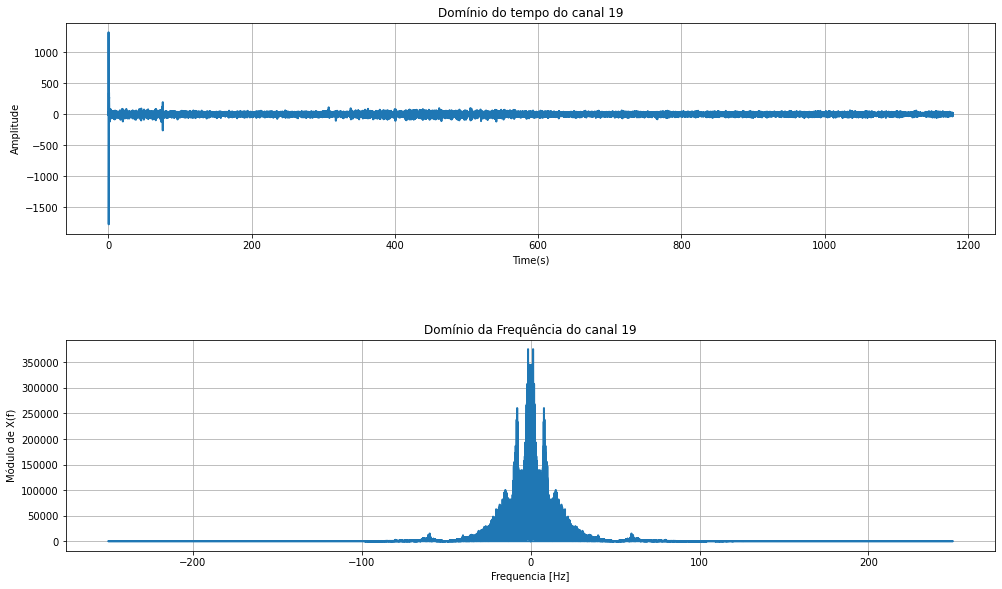

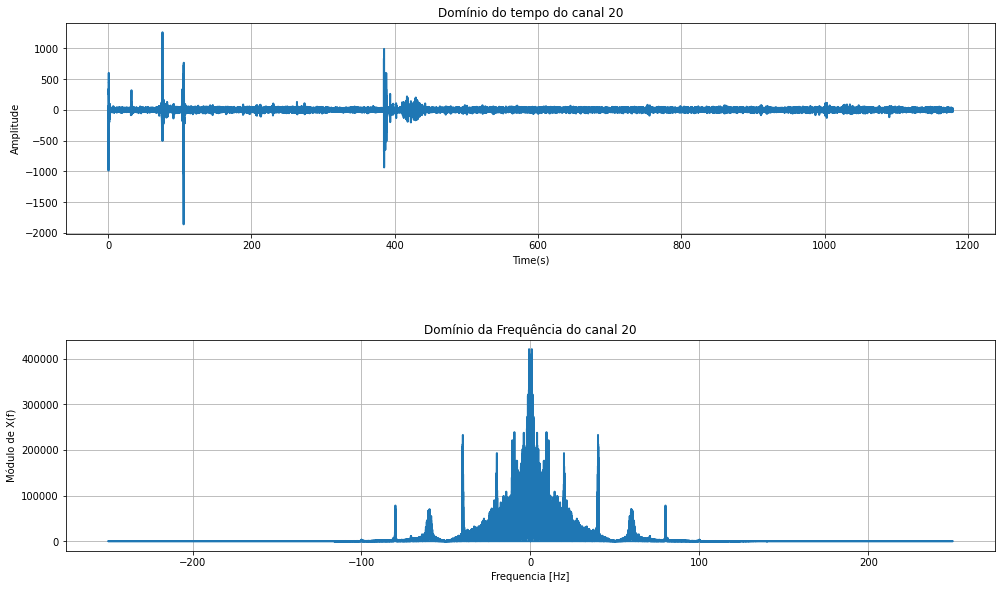

In [ ]:
# Após ver que são 20 canais, cadas um com tamanho de 589409, vou fazer o plot de cada um dos canais e observar sua resp no tempo e em freq
for i in range(20):
  canais_sinal = x[::,i] # O valor de i determina o canal vigente, no caso de i ser 0, o canal é o canal 1
  title = ' do canal ' + str(i+1)
  temp_grafico_freq(canais_sinal,fs,title)

## Arquivo T1_p1

Vou fazer o mesmo processo para a pasta T1, agora com o arquivo T1_p1.mat.

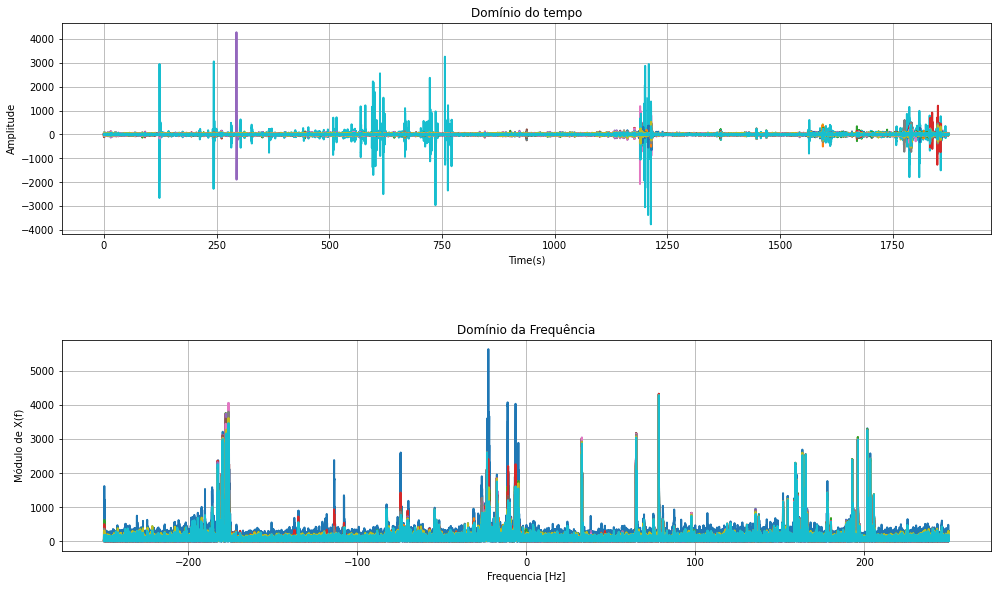

In [ ]:
x_p1 = dados_T1[11]
temp_grafico_freq(x_p1,fs)

In [ ]:
x_p1.shape

(936930, 20)

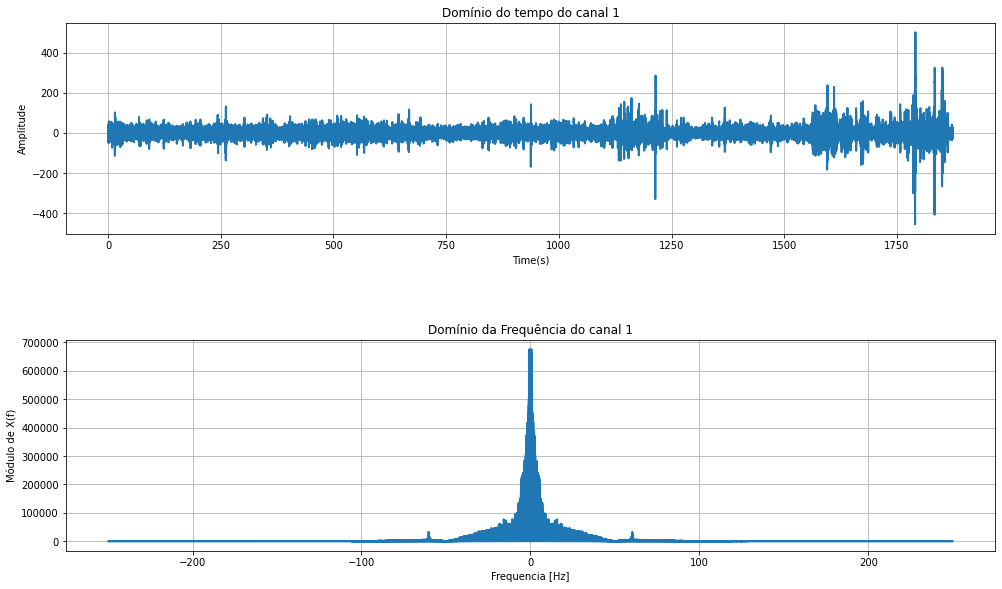

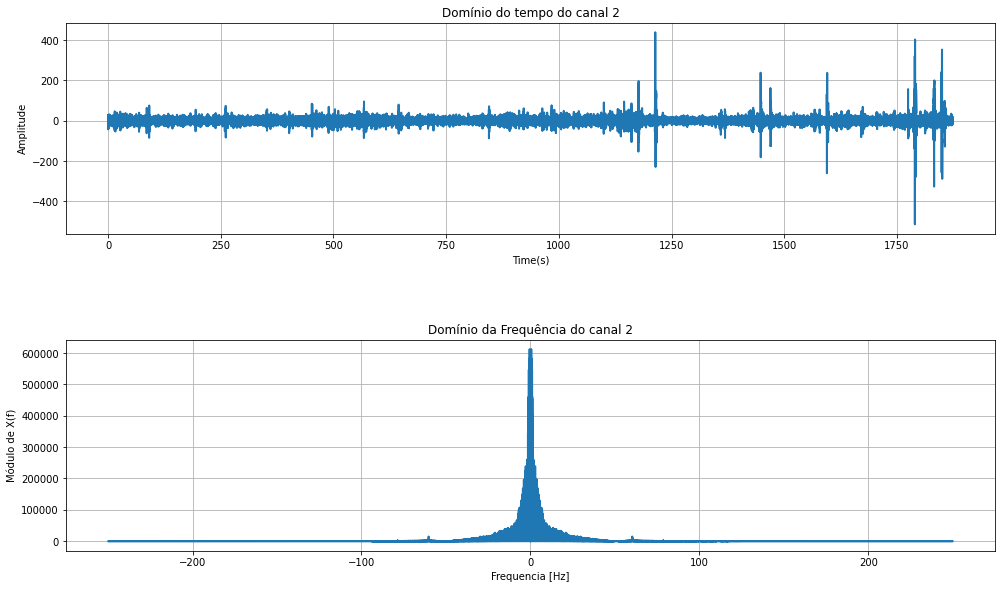

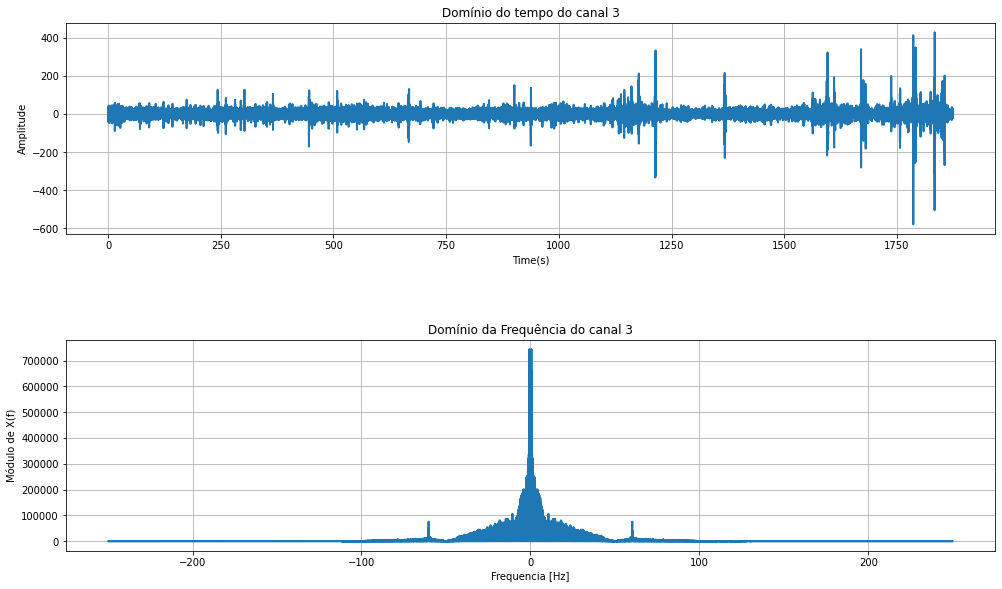

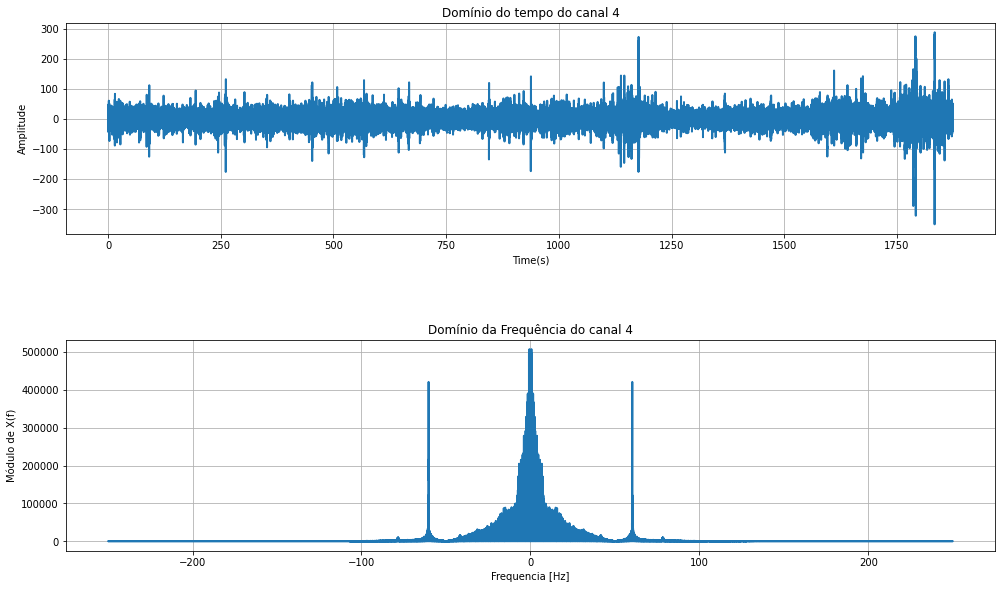

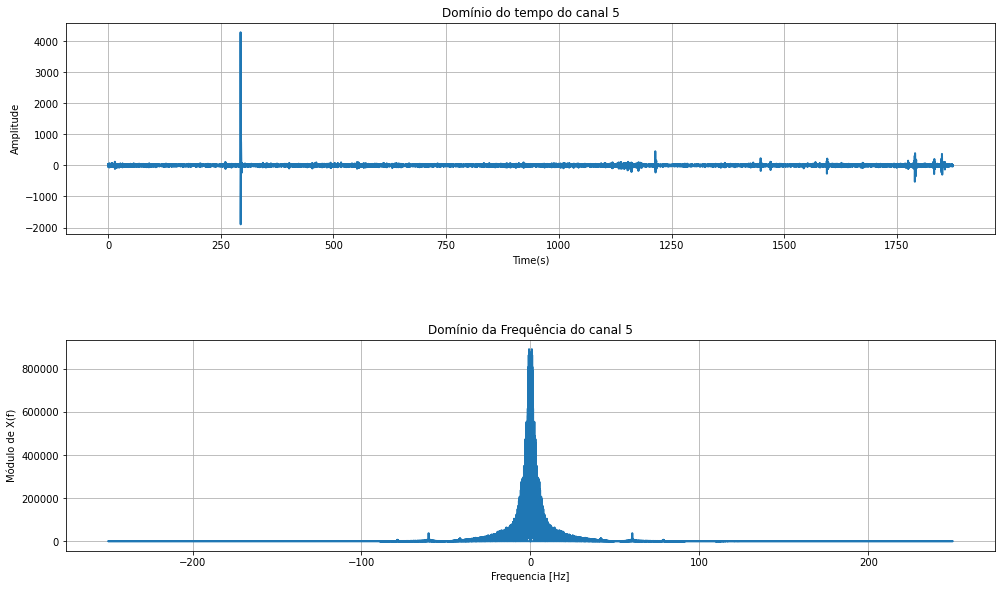

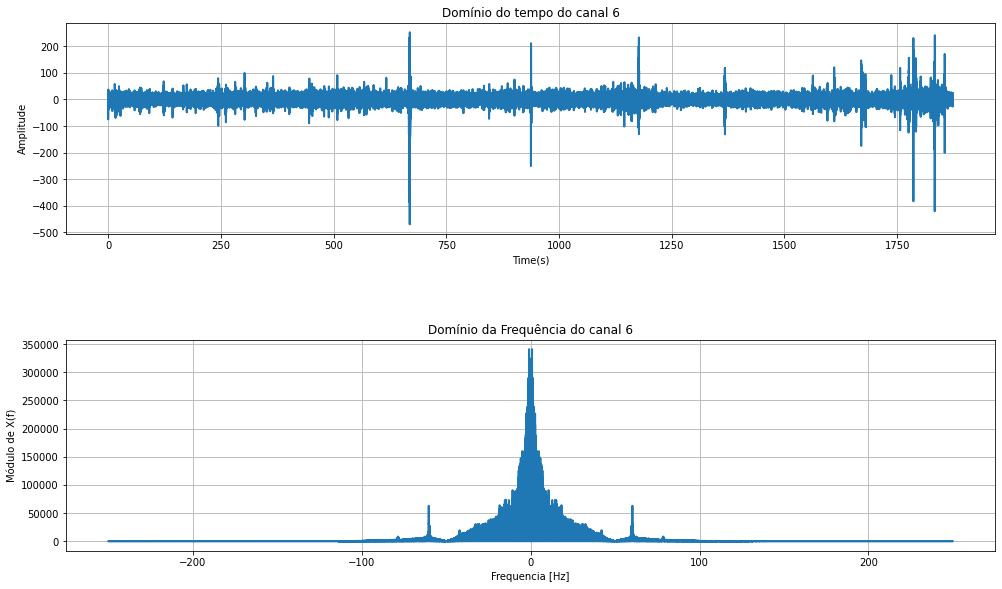

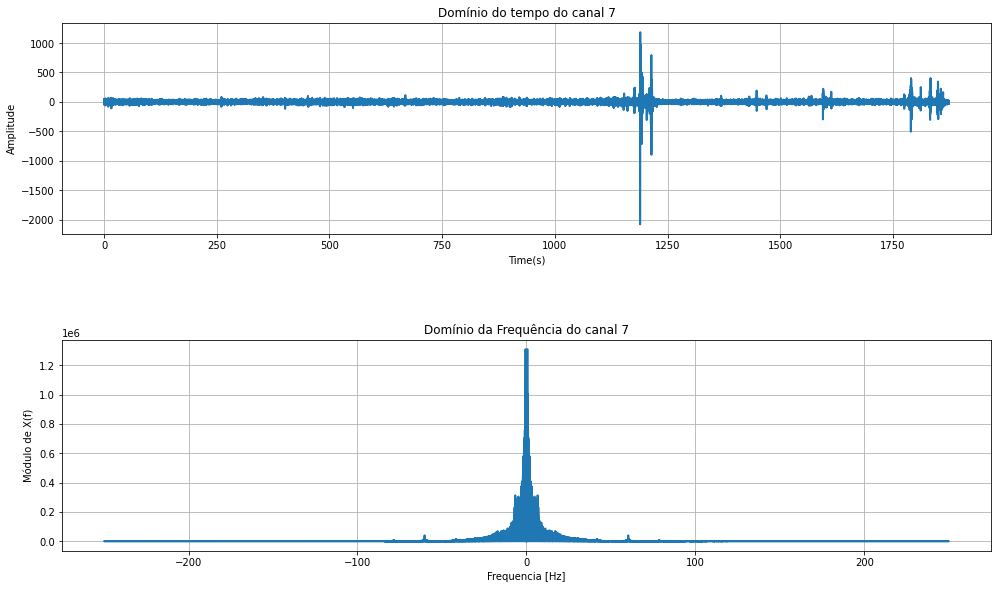

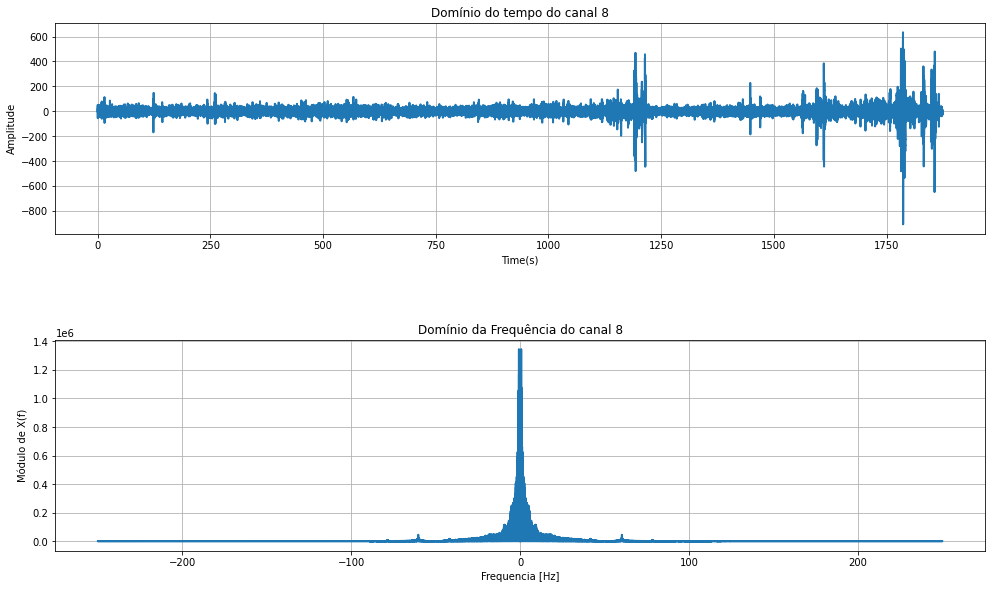

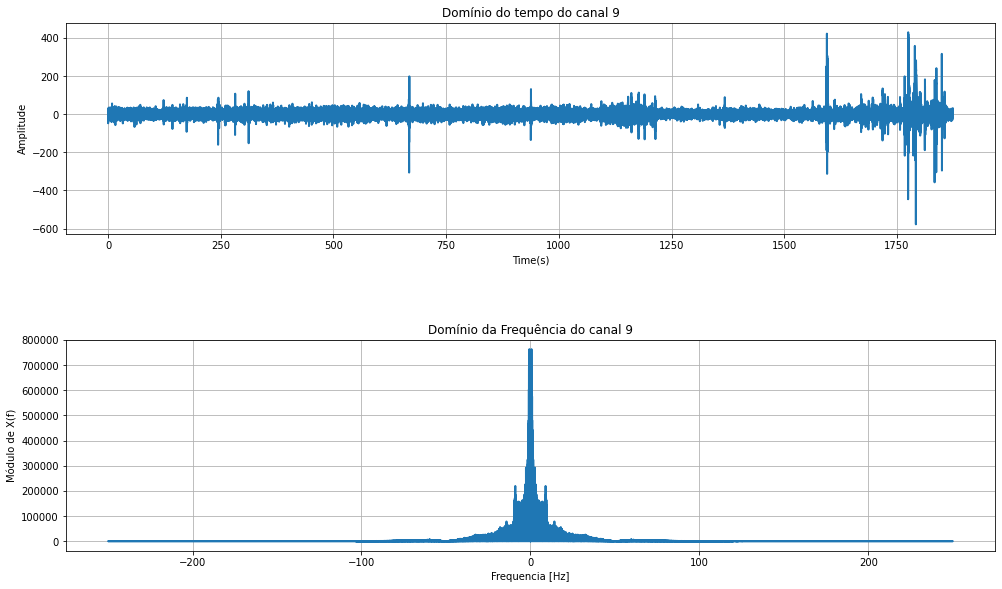

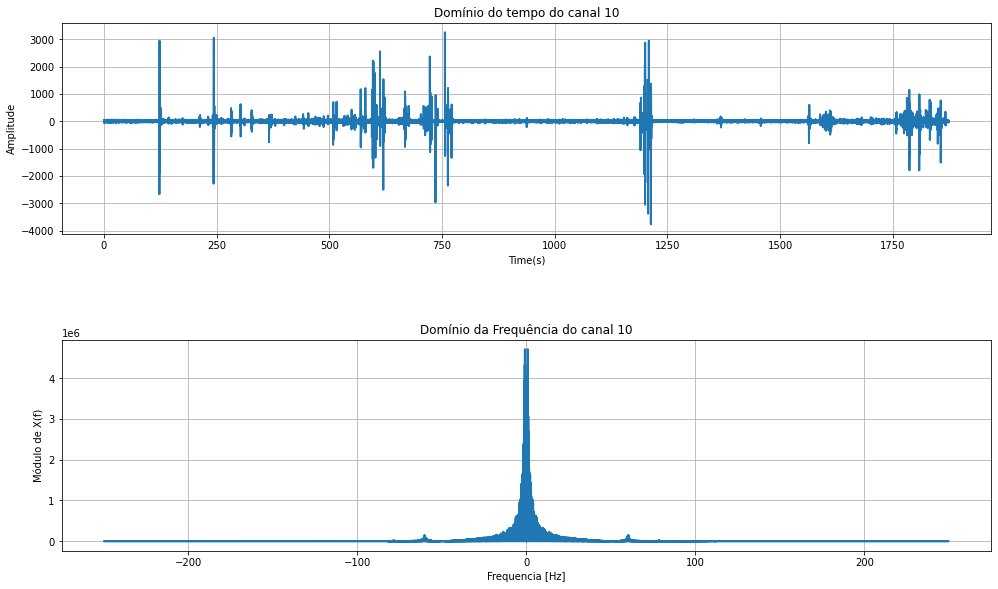

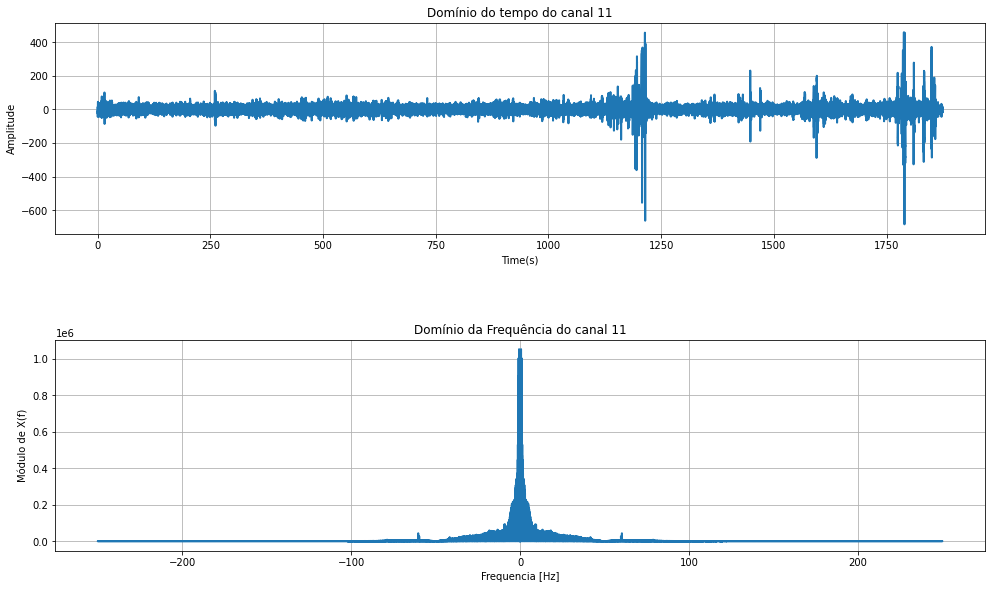

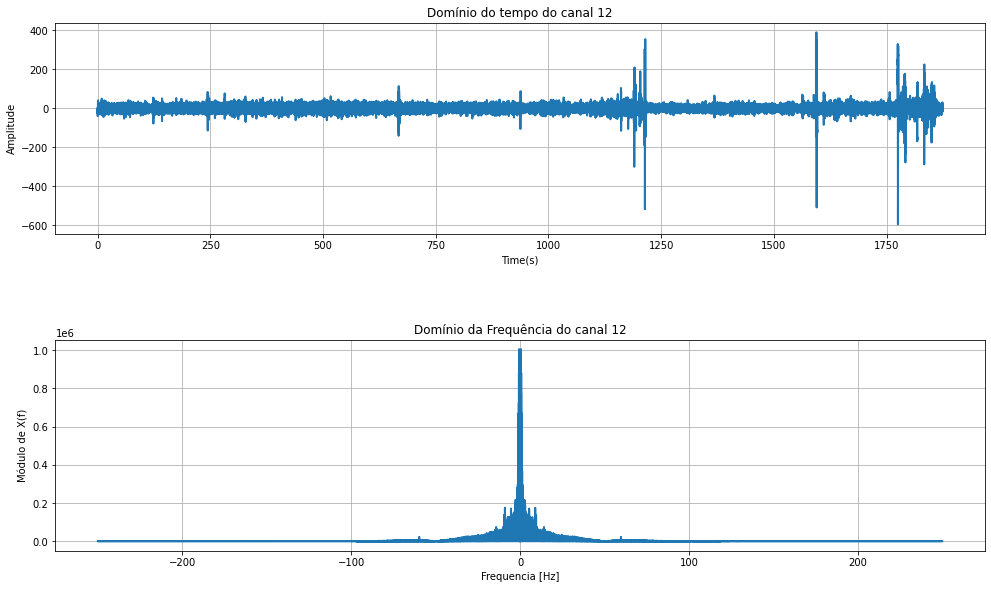

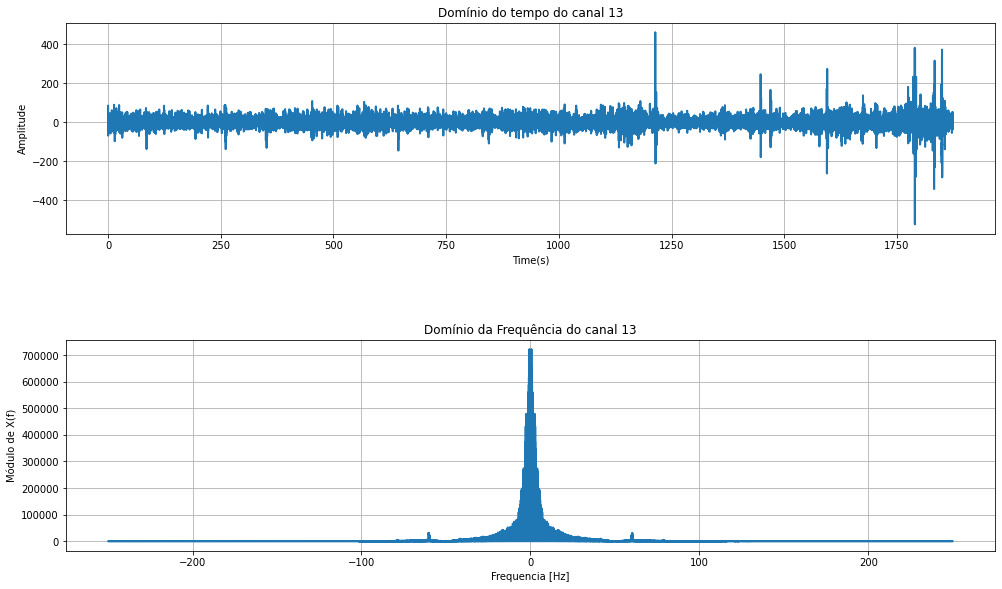

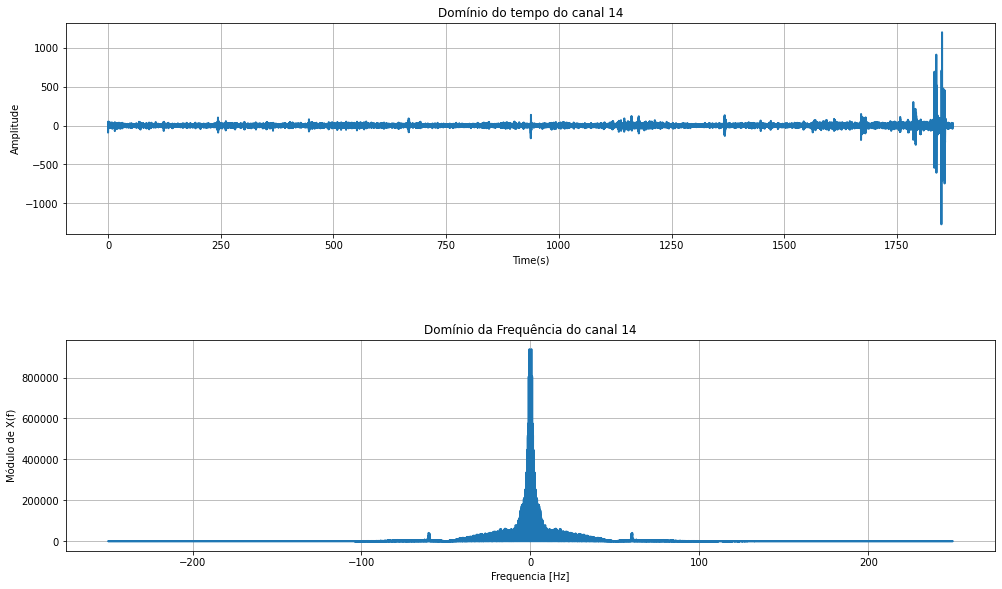

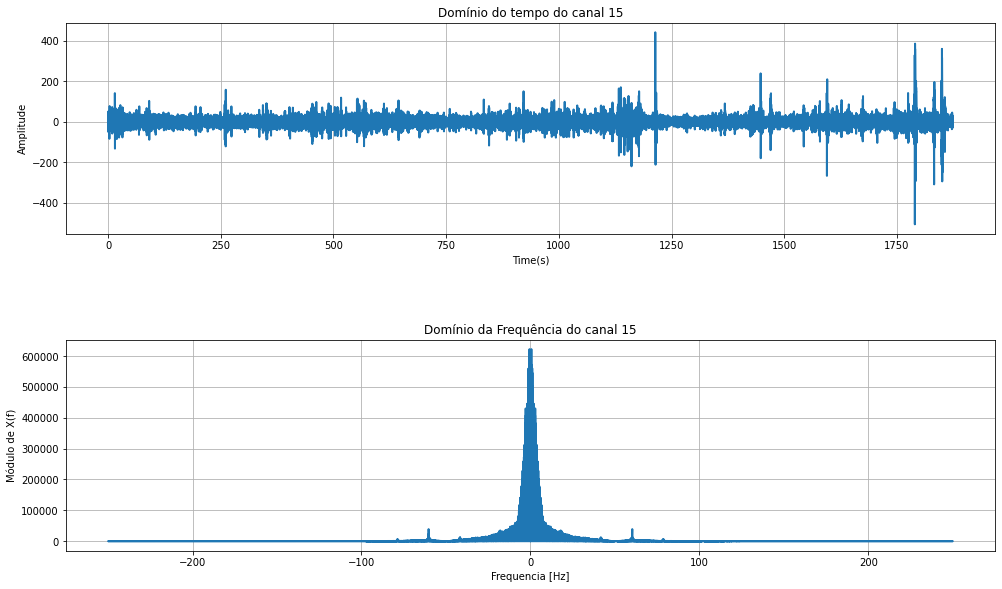

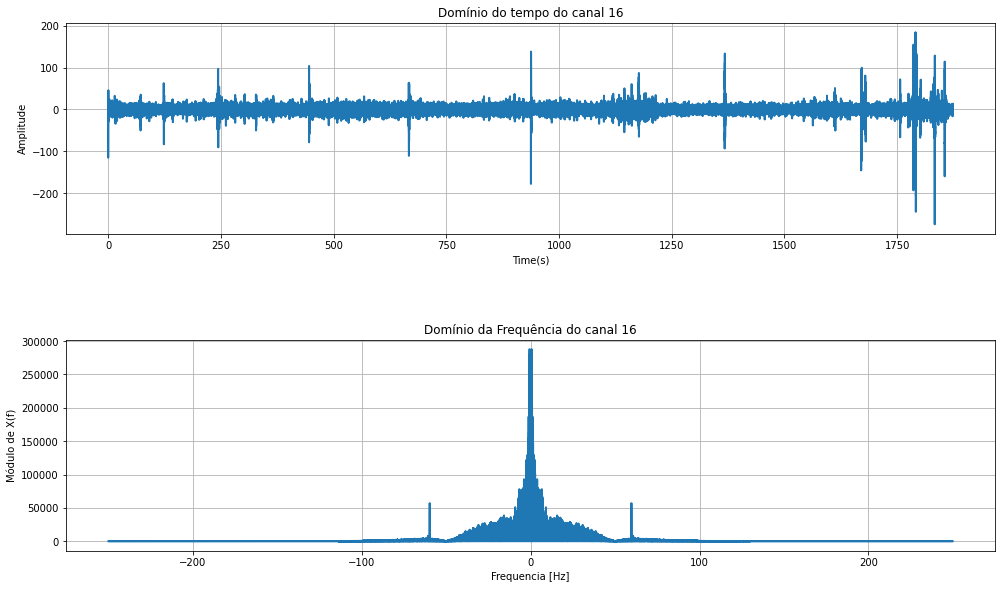

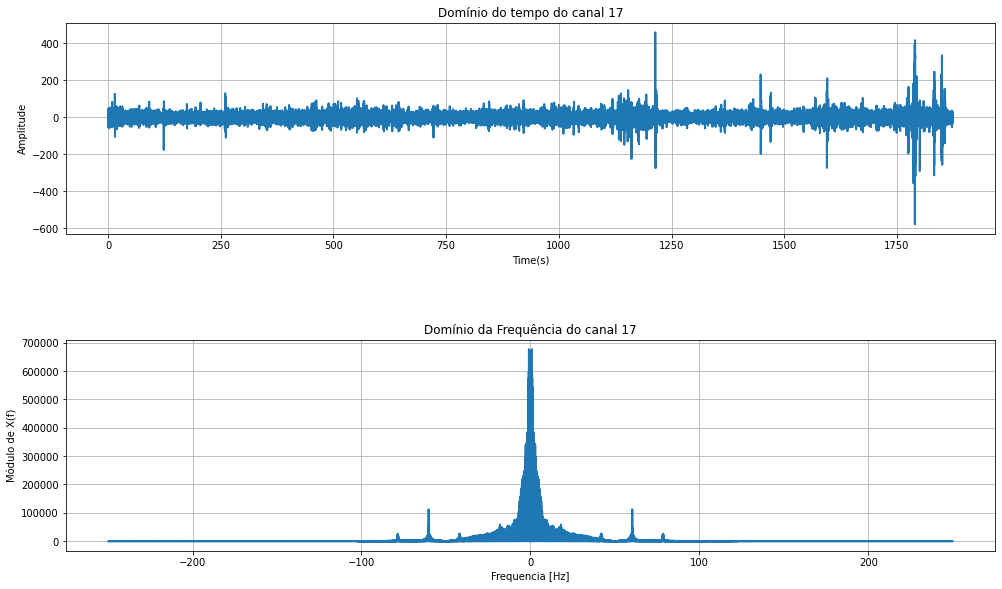

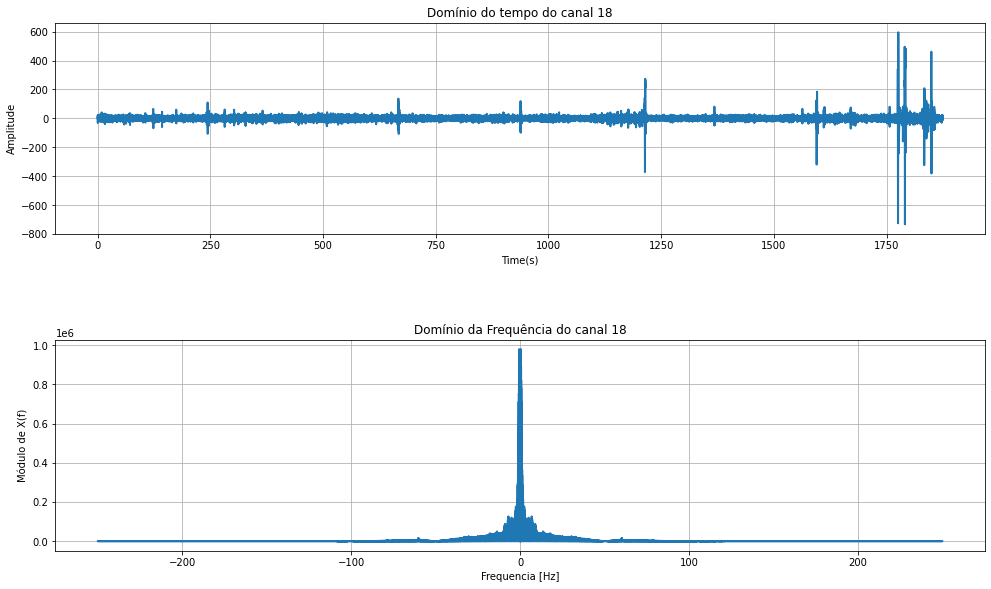

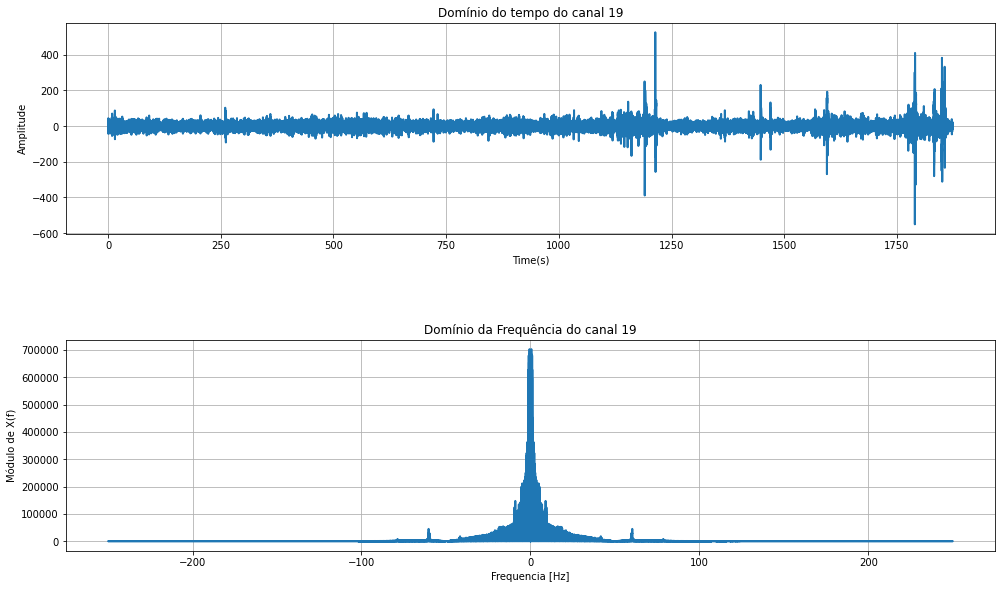

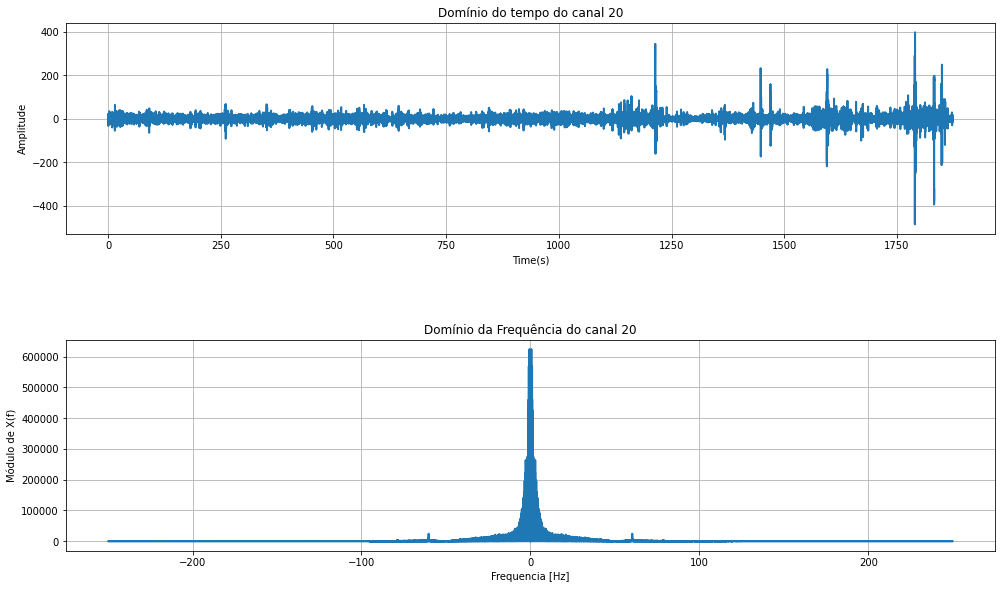

In [ ]:
#Após ver que são 20 canais, cadas um com tamanho de 936930, vou fazer o plot de cada um dos canais e observar sua resp no tempo e em freq
for i in range(20):
  canais_sinal = x_p1[::,i] # O valor de i determina o canal vigente, no caso de i ser 0, o canal é o canal 1
  title = ' do canal ' + str(i+1)
  temp_grafico_freq(canais_sinal,fs,title)

## Janelamento do sinal x_p1 sem sobreposição




Como o sinal é muito grande no domínio do tempo, nesse caso, acima de 1000 segundos, decidimos inicialmente fazer um janelamento de 60s para tratar e observar o comportamento do sinal em intervalos menores.

In [ ]:
canal_1 = x_p1[::,0] # Canal 1 do sinal x_p1
print(len(canal_1)) # O sinal de X_p1 tem duração de 17,5495 minutos = 17 minutos e 32,97 segundos = 1052,97 segundos
#Escolhemos fazer o janelamento a cada 300ms segundos
janela = int(0.3*500) # 300ms segundos multiplicado pela frequência de amostragem do sinal, então cada janela terá 125 pontos

936930


In [ ]:
sinal_janelado = janelamento(canal_1,janela)

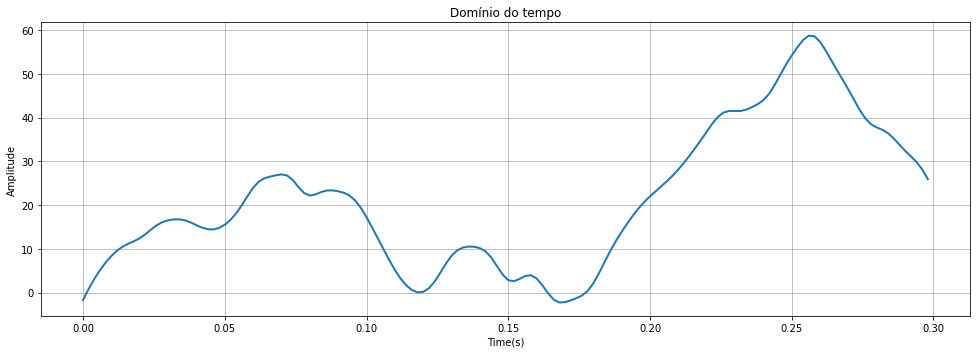

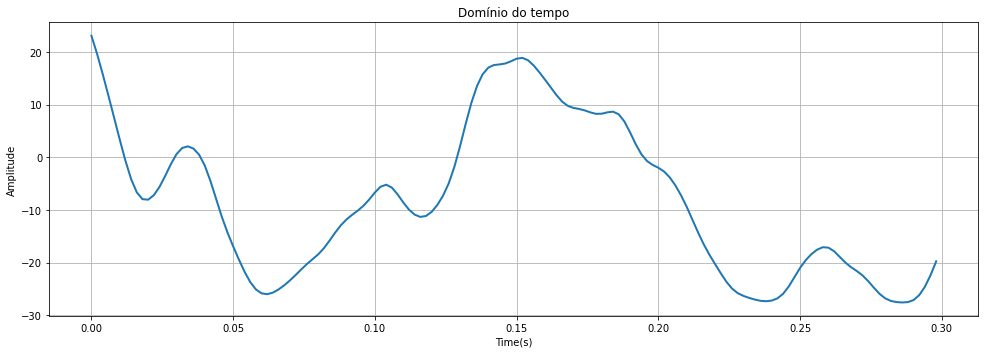

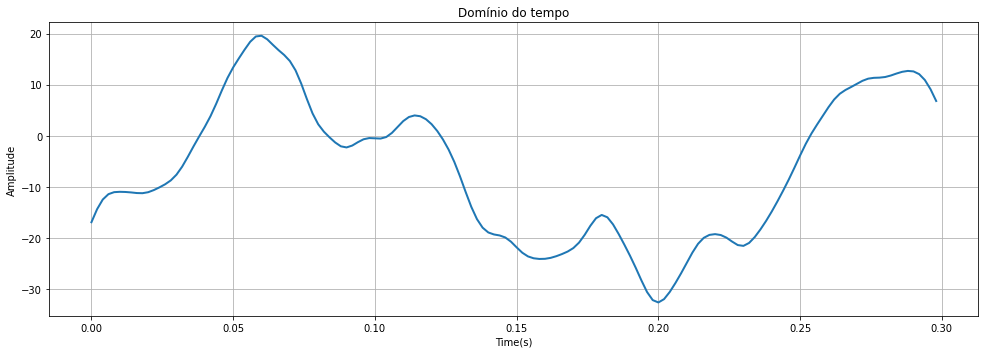

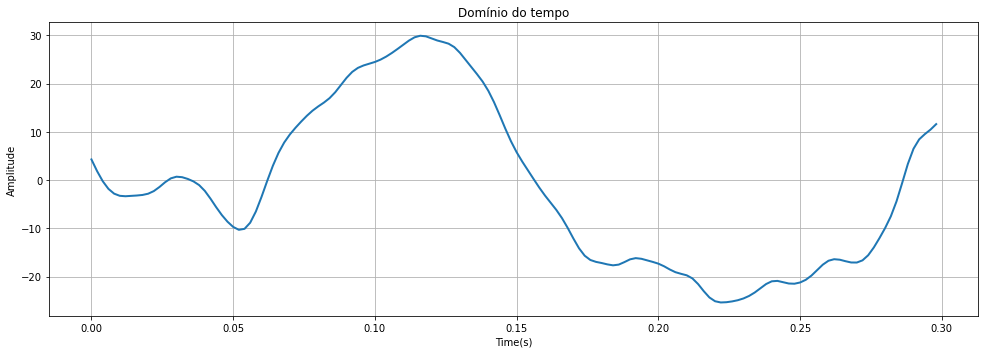

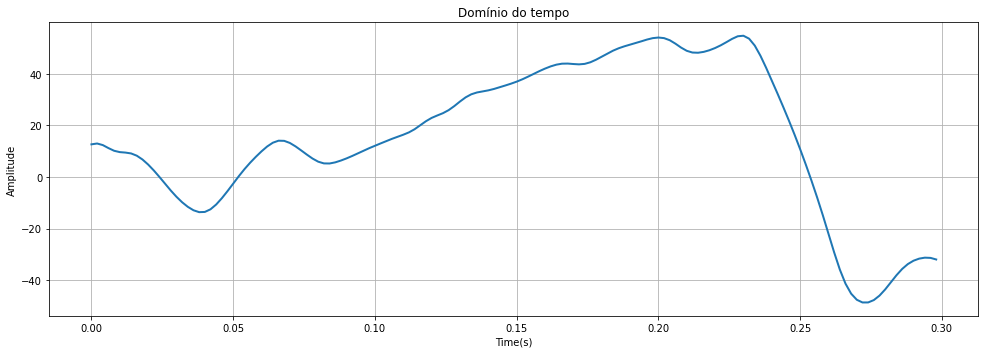

In [ ]:
for i in range(5,10):
  temp_grafico_freq(sinal_janelado[i],fs,'',False)

## Janelamento do sinal x_p1 com sobreposição

In [ ]:
canal_1 = x_p1[::,0] # Canal 1 do sinal x_p1
print(len(canal_1)) # O sinal de X_p1 tem duração de 17,5495 minutos = 17 minutos e 32,97 segundos = 1052,97 segundos
#Escolhemos fazer o janelamento a cada 1s segundos com sobreposição de 250ms

936930


In [ ]:
janelamento_sobreposicao = janelamento_sbp(canal_1,1,0.25,fs)

In [ ]:
print(len(janelamento_sobreposicao))

1874


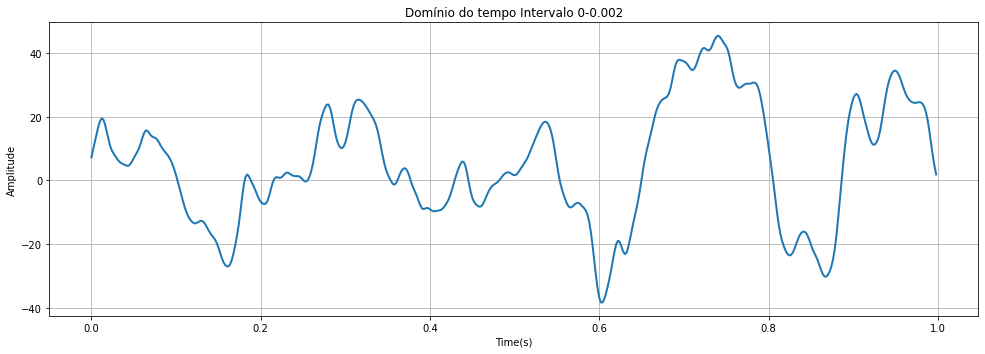

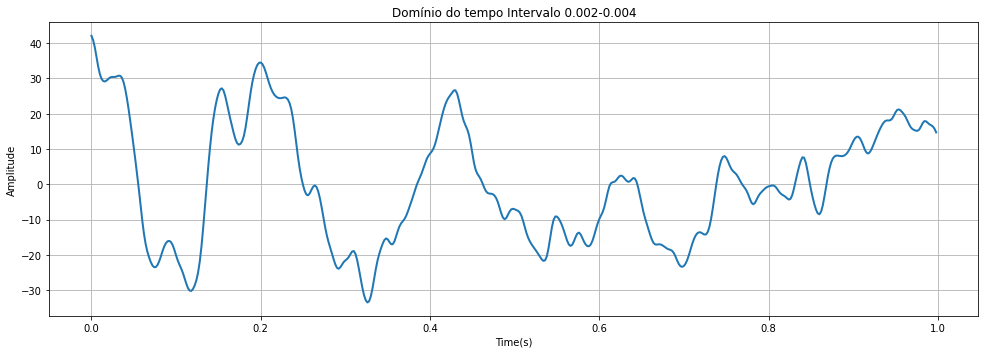

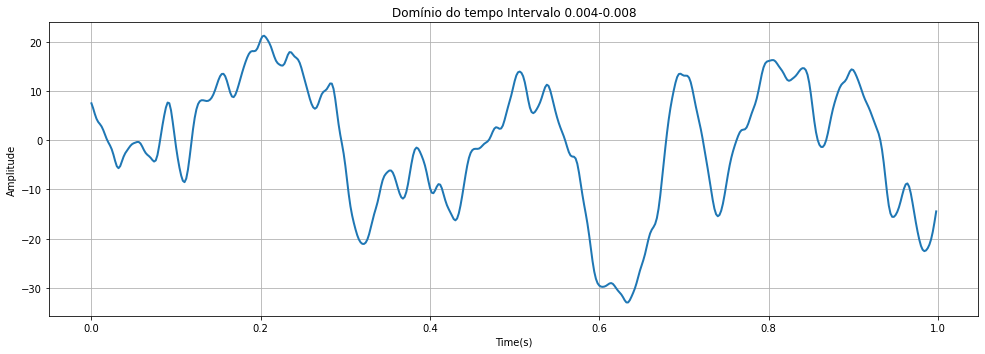

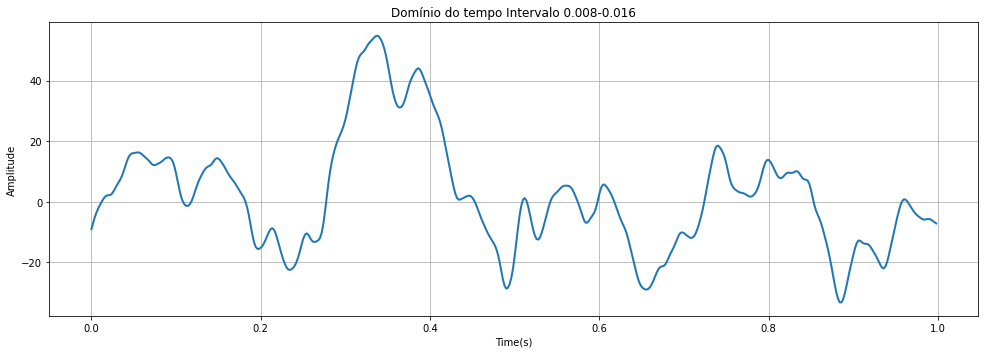

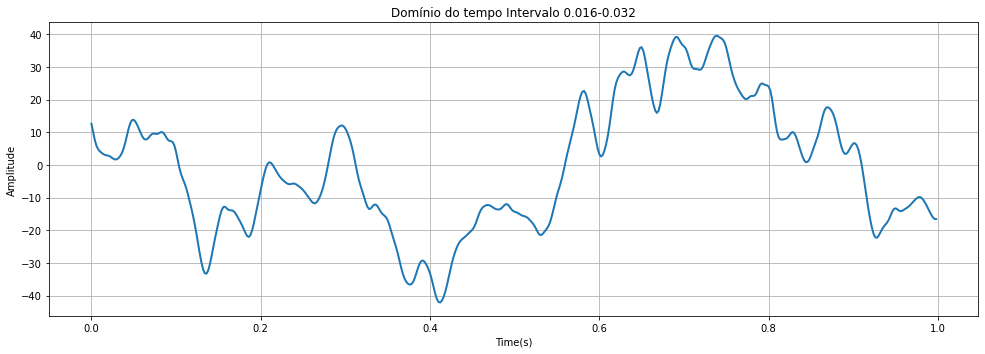

In [ ]:
tempo = 1/fs 
inicio=0
for i in range(6,11):
  title = " Intervalo " + str(inicio) + "-" + str(tempo)
  temp_grafico_freq(janelamento_sobreposicao[i],fs,title,False)
  inicio = tempo
  tempo = tempo + tempo

# Filtros

## Teste de ordem com um janelamento

In [ ]:
xn = janelamento_sobreposicao[6]

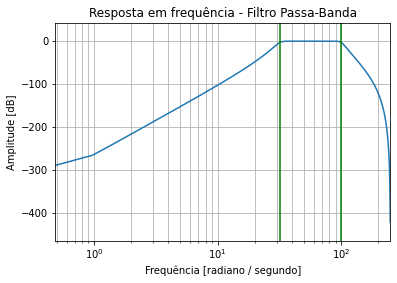

In [ ]:
# Esses valores, assim como a ordem foram sendo modificados e ajustados para cada faixa de frequência
baixo = 32 
alto = 100

b,a = filtro_butter([baixo,alto],8,fs)
visualizar_filtro(b,a,fs,[baixo,alto])

In [ ]:
sinal_filtrado = signal.filtfilt(b, a, xn)

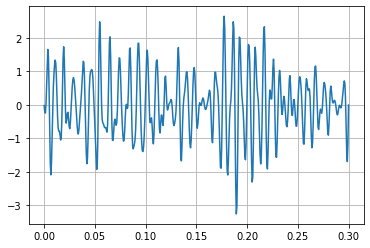

In [ ]:
t = np.linspace(0, 0.3, 500)
plt.figure
#plt.plot(t, xn)
plt.plot(t,sinal_filtrado)
plt.grid(True)
plt.show()

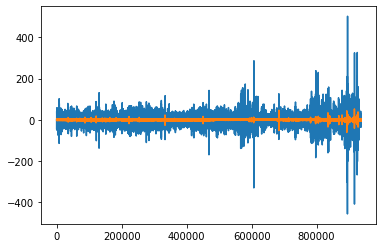

In [ ]:
vetor = x_p1[::,0]
vet = vetor
zp = signal.filtfilt(b, a, vet)
plt.plot(vet)
plt.plot(zp)
plt.show()

## Formação dos filtros

In [ ]:
# Vetores para guardar informações das faixas de frequências e ordens dos filtros que a gente escolheu.
faixa_frequencias = [[0.1,4],[4,8],[8,13],[13,15],[15,32],[32,100]]
ordens = [3,5,5,5,8,8]

In [ ]:
coeficientes_filtros = []
for i in range(len(ordens)):
  coefs = filtro_butter(faixa_frequencias[i],ordens[i],fs)
  coeficientes_filtros.append(coefs)

## Abaixo contém apenas uma pequena visualização de como o filtro é aplicado (ficar mais fácil de entender)

### Filtro 0.1 - 4hz - Delta

In [ ]:
filtracao_delta = []
for i in range(len(janelamento_sobreposicao)):
  filtrado = signal.filtfilt(coeficientes_filtros[0][0], coeficientes_filtros[0][1], janelamento_sobreposicao[i])
  filtracao_delta.append(filtrado)

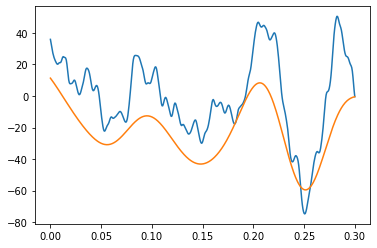

In [ ]:
plt.plot(t,janelamento_sobreposicao[11])
plt.plot(t,filtracao_delta[11])

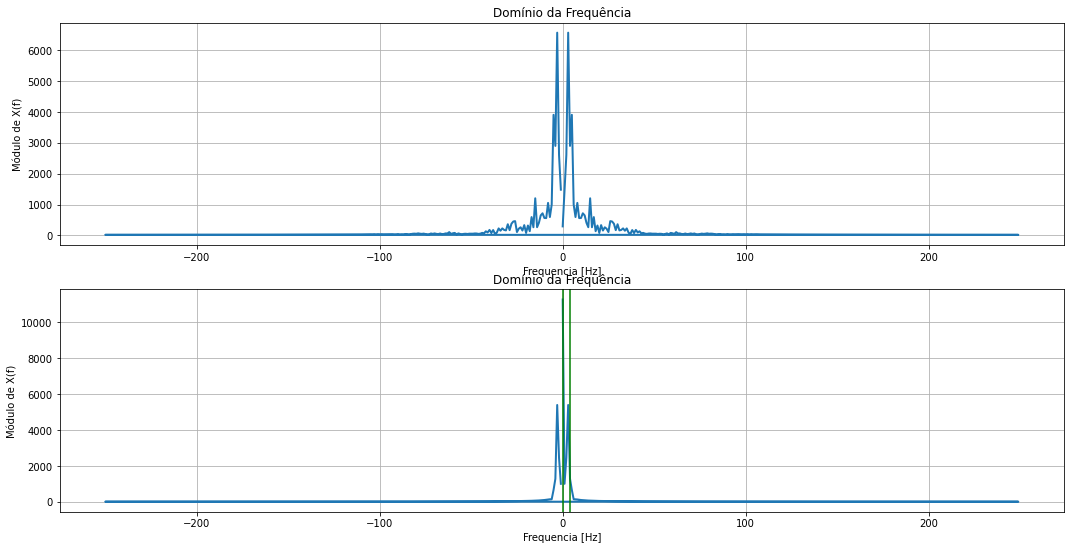

In [ ]:
N_pontos = len(janelamento_sobreposicao[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

Xf = fft(janelamento_sobreposicao[11]) 
figure, (ax1,ax2) = plt.subplots(2, 1,figsize=(18,9))
ax1.plot(frequenciaHz, abs(Xf), linewidth=2)
ax1.set_title("Domínio da Frequência")
ax1.set_xlabel("Frequencia [Hz]")
ax1.set_ylabel("Módulo de X(f)")
ax1.grid()

X2 = fft(filtracao_delta[11])
N_pontos = len(filtracao_delta[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

ax2.plot(frequenciaHz, abs(X2), linewidth=2)
ax2.set_title("Domínio da Frequência")
ax2.set_xlabel("Frequencia [Hz]")
ax2.set_ylabel("Módulo de X(f)")
ax2.grid()

plt.axvline(0.1, color='green')
plt.axvline(4, color='green') 

### Filtro 4 - 8hz - Theta

In [ ]:
filtracao_theta = []
for i in range(len(janelamento_sobreposicao)):
  filtrado = signal.filtfilt(coeficientes_filtros[1][0], coeficientes_filtros[1][1], janelamento_sobreposicao[i])
  filtracao_theta.append(filtrado)

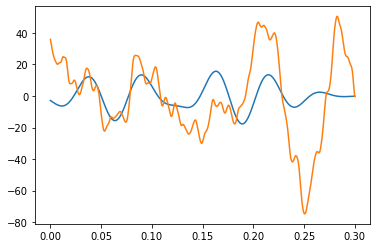

In [ ]:
t = np.linspace(0, 0.3, 500)
plt.plot(t,filtracao_theta[11])
plt.plot(t,janelamento_sobreposicao[11])

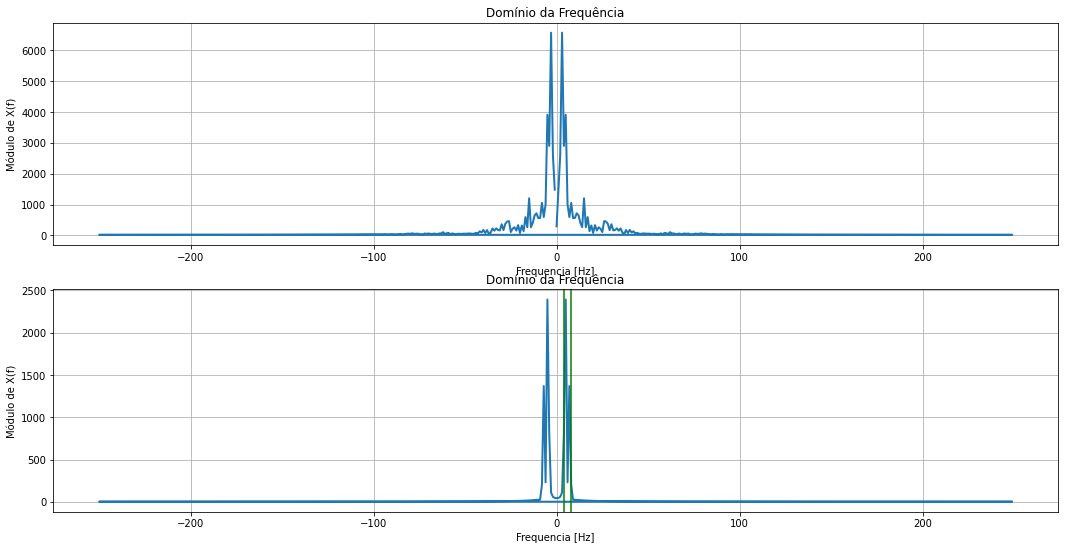

In [ ]:
N_pontos = len(janelamento_sobreposicao[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

Xf = fft(janelamento_sobreposicao[11]) 
figure, (ax1,ax2) = plt.subplots(2, 1,figsize=(18,9))
ax1.plot(frequenciaHz, abs(Xf), linewidth=2)
ax1.set_title("Domínio da Frequência")
ax1.set_xlabel("Frequencia [Hz]")
ax1.set_ylabel("Módulo de X(f)")
ax1.grid()

X2 = fft(filtracao_theta[11])
N_pontos = len(filtracao_theta[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

ax2.plot(frequenciaHz, abs(X2), linewidth=2)
ax2.set_title("Domínio da Frequência")
ax2.set_xlabel("Frequencia [Hz]")
ax2.set_ylabel("Módulo de X(f)")
ax2.grid()

plt.axvline(4, color='green') 
plt.axvline(8, color='green') 

### Filtro 8 - 13hz - Alpha

In [ ]:
filtracao_alpha = []
for i in range(len(janelamento_sobreposicao)):
  filtrado = signal.filtfilt(coeficientes_filtros[2][0], coeficientes_filtros[2][1], janelamento_sobreposicao[i])
  filtracao_alpha.append(filtrado)

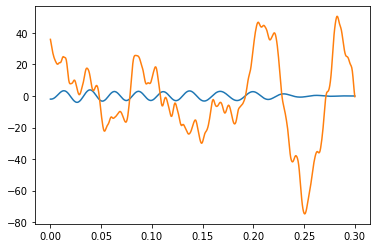

In [ ]:
t = np.linspace(0, 0.3,500)
plt.plot(t,filtracao_alpha[11])
plt.plot(t,janelamento_sobreposicao[11])

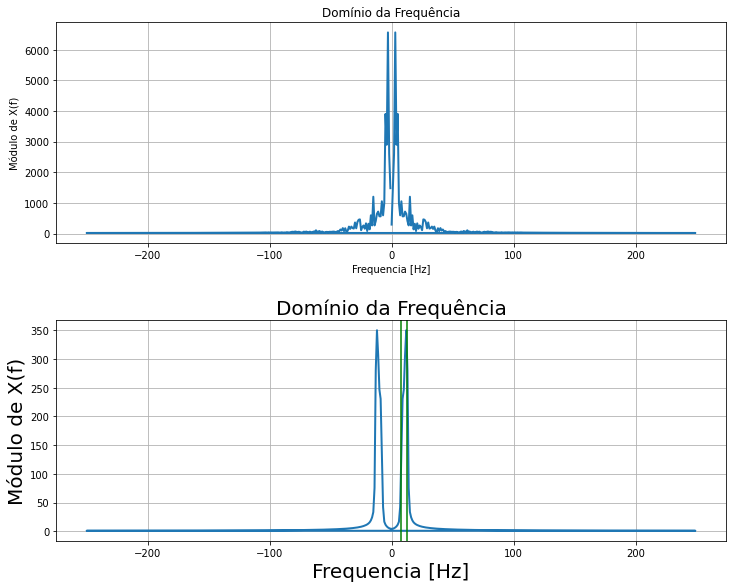

In [ ]:
N_pontos = len(janelamento_sobreposicao[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

Xf = fft(janelamento_sobreposicao[11]) 
figure, (ax1,ax2) = plt.subplots(2, 1,figsize=(12,9))
ax1.plot(frequenciaHz, abs(Xf), linewidth=2)
ax1.set_title("Domínio da Frequência")
ax1.set_xlabel("Frequencia [Hz]")
ax1.set_ylabel("Módulo de X(f)")
ax1.grid()

X2 = fft(filtracao_alpha[11])
N_pontos = len(filtracao_alpha[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

ax2.plot(frequenciaHz, abs(X2), linewidth=2)
ax2.set_title("Domínio da Frequência",{'fontsize': 20})
ax2.set_xlabel("Frequencia [Hz]",{'fontsize': 20})
ax2.set_ylabel("Módulo de X(f)",{'fontsize': 20})
ax2.grid()

plt.axvline(8, color='green') # cutoff frequency
plt.axvline(13, color='green') # cutoff frequency

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

### Filtro 13 - 15hz - Beta Baixa

In [ ]:
filtracao_BetaB = []
for i in range(len(janelamento_sobreposicao)):
  filtrado = signal.filtfilt(coeficientes_filtros[3][0], coeficientes_filtros[3][1], janelamento_sobreposicao[i])
  filtracao_BetaB.append(filtrado)

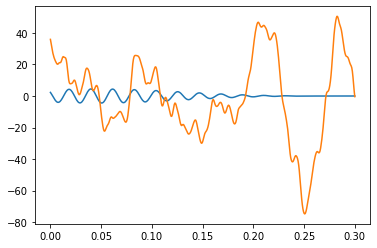

In [ ]:
t = np.linspace(0, 0.3, 500)
plt.plot(t,filtracao_BetaB[11])
plt.plot(t,janelamento_sobreposicao[11])

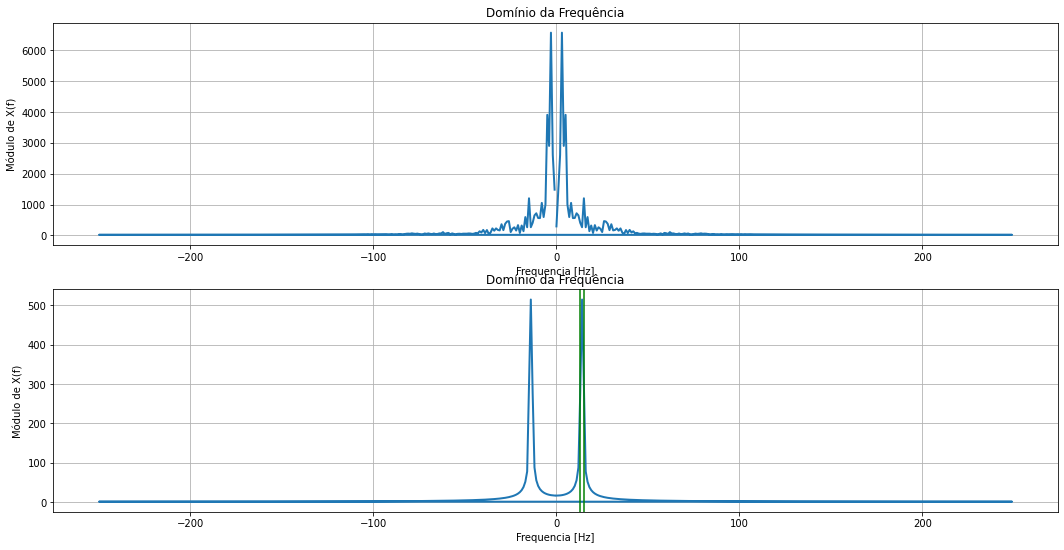

In [ ]:
N_pontos = len(janelamento_sobreposicao[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

Xf = fft(janelamento_sobreposicao[11]) 
figure, (ax1,ax2) = plt.subplots(2, 1,figsize=(18,9))
ax1.plot(frequenciaHz, abs(Xf), linewidth=2)
ax1.set_title("Domínio da Frequência")
ax1.set_xlabel("Frequencia [Hz]")
ax1.set_ylabel("Módulo de X(f)")
ax1.grid()

X2 = fft(filtracao_BetaB[11])
N_pontos = len(filtracao_BetaB[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

ax2.plot(frequenciaHz, abs(X2), linewidth=2)
ax2.set_title("Domínio da Frequência")
ax2.set_xlabel("Frequencia [Hz]")
ax2.set_ylabel("Módulo de X(f)")
ax2.grid()

plt.axvline(13, color='green') # cutoff frequency
plt.axvline(15, color='green') # cutoff frequency

### Filtro 15 - 32hz - Beta

In [ ]:
filtracao_Beta = []
for i in range(len(janelamento_sobreposicao)):
  filtrado = signal.filtfilt(coeficientes_filtros[4][0], coeficientes_filtros[4][1], janelamento_sobreposicao[i])
  filtracao_Beta.append(filtrado)

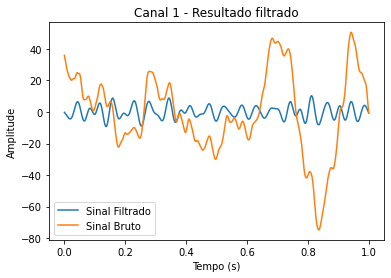

In [ ]:
t = np.linspace(0, 1, 500)
plt.plot(t,filtracao_Beta[11],label='Sinal Filtrado')
plt.plot(t,janelamento_sobreposicao[11],label='Sinal Bruto')
plt.xlabel('Tempo (s)')
plt.title('Canal 1 - Resultado filtrado')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

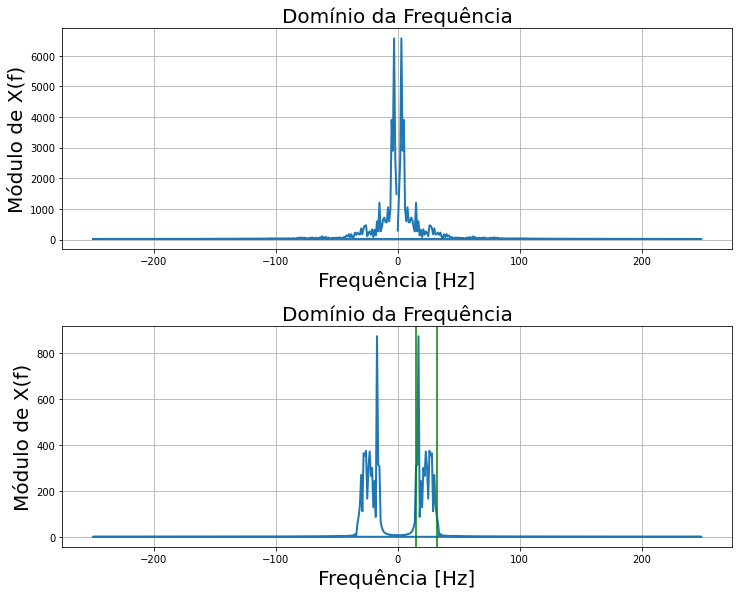

In [ ]:
N_pontos = len(janelamento_sobreposicao[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

Xf = fft(janelamento_sobreposicao[11]) 
figure, (ax1,ax2) = plt.subplots(2, 1,figsize=(12,9))
ax1.plot(frequenciaHz, abs(Xf), linewidth=2)
ax1.set_title("Domínio da Frequência",{'fontsize': 20})
ax1.set_xlabel("Frequência [Hz]",{'fontsize': 20})
ax1.set_ylabel("Módulo de X(f)",{'fontsize': 20})
ax1.grid()

X2 = fft(filtracao_Beta[11])
N_pontos = len(filtracao_Beta[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

ax2.plot(frequenciaHz, abs(X2), linewidth=2)
ax2.set_title("Domínio da Frequência",{'fontsize': 20})
ax2.set_xlabel("Frequência [Hz]",{'fontsize': 20})
ax2.set_ylabel("Módulo de X(f)",{'fontsize': 20})
ax2.grid()

plt.axvline(15, color='green') # cutoff frequency
plt.axvline(32, color='green') # cutoff frequency

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

### Filtro 32 - 100hz - Gama

In [ ]:
filtracao_Gama = []
for i in range(len(janelamento_sobreposicao)):
  filtrado = signal.filtfilt(coeficientes_filtros[5][0], coeficientes_filtros[5][1], janelamento_sobreposicao[i])
  filtracao_Gama.append(filtrado)

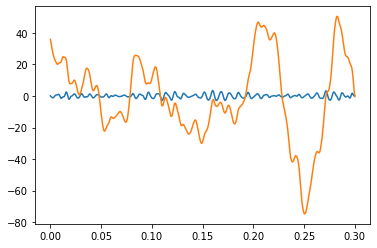

In [ ]:
t = np.linspace(0, 0.3, 500)
plt.plot(t,filtracao_Gama[11])
plt.plot(t,janelamento_sobreposicao[11])

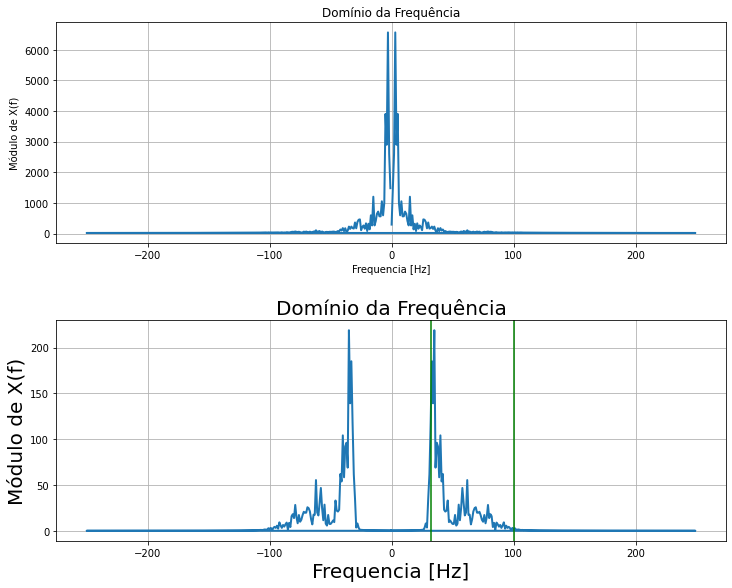

In [ ]:
N_pontos = len(janelamento_sobreposicao[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

Xf = fft(janelamento_sobreposicao[11]) 
figure, (ax1,ax2) = plt.subplots(2, 1,figsize=(12,9))
ax1.plot(frequenciaHz, abs(Xf), linewidth=2)
ax1.set_title("Domínio da Frequência")
ax1.set_xlabel("Frequencia [Hz]")
ax1.set_ylabel("Módulo de X(f)")
ax1.grid()

X2 = fft(filtracao_Gama[11])
N_pontos = len(filtracao_Gama[11]) 
ts = 1 / fs 
t = arange(0, N_pontos) * ts 
frequenciaHz = fftfreq(N_pontos, ts)

ax2.plot(frequenciaHz, abs(X2), linewidth=2)
ax2.set_title("Domínio da Frequência",{'fontsize': 20})
ax2.set_xlabel("Frequencia [Hz]",{'fontsize': 20})
ax2.set_ylabel("Módulo de X(f)",{'fontsize': 20})
ax2.grid()

plt.axvline(32, color='green') # cutoff frequency
plt.axvline(100, color='green') # cutoff frequency

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

# Aplicação de todos os dados da base à metodologia

In [ ]:
# Essa é a parte que demora MIL ANOS 
dados_T1_atributos = janelamento_sob_extracao(dados_T1,'T1',0.3,0.1,fs) # Utilizando a função
dados_T0_atributos = janelamento_sob_extracao(dados_T0,'T0',0.3,0.1,fs) # Utilizando a função


# Separamos em algumas partes para os arquivos serem adicionados no csv por partes para analisar o que estava ocorrendo.
#PARA DADOS T1:
#[0,6],[6,10],[10,13]

#PARA T0:
#[0:4],[4:7],[7:10],[10,11],[11:13],[13:14]

In [ ]:
# Utilizando um novo janelamento e uma nova sobreposição
dados_T1_atributos2 = janelamento_sob_extracao(dados_T1,'T1',1,0.25,fs) # Utilizando a função com janelamento de 1s e sobreposicao de 0.25
dados_T0_atributos2 = janelamento_sob_extracao(dados_T0,'T0',1,0.25,fs) # Utilizando a função

## Criação do csv

In [ ]:
'''Rodar apenas uma vez
criar_csv('/content/drive/MyDrive/Trabalho-PDS/csv/dados.csv',3480)
'''

In [ ]:
''' Rodas apenas uma vez
preencher_csv('/content/drive/MyDrive/Trabalho-PDS/csv/dados.csv',dados_T0_atributos)
preencher_csv('/content/drive/MyDrive/Trabalho-PDS/csv/dados.csv',dados_T1_atributos)
'''

In [ ]:
'''Rodar apenas uma vez
criar_csv('/content/drive/MyDrive/Trabalho-PDS/csv/dados2.csv',3480)
'''

In [ ]:
''' Rodas apenas uma vez
preencher_csv('/content/drive/MyDrive/Trabalho-PDS/csv/dados2.csv',dados_T0_atributos2)
preencher_csv('/content/drive/MyDrive/Trabalho-PDS/csv/dados2.csv',dados_T1_atributos2)
'''